# **Bike Sharing_ Timeseries Prediction Model**

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

### O. Importing Libraries and Loading the Data:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, r2_score

In [2]:
#libraries related to pycaret:
from pycaret.regression import create_model, tune_model
from pycaret.regression import setup, create_model, tune_model, plot_model, compare_models, finalize_model
from pycaret.regression import plot_model
from pycaret.regression import create_model, tune_model, plot_model, compare_models
from pycaret.regression import tune_model
from pycaret.regression import *
import os 

In [3]:
#for graphs and data viz
from IPython.display import display

In [4]:
data = pd.read_csv("bike-sharing_hourly.csv")

### 1. Preliminary Data Check:     
In this part we will look at the data to understand its basic structure, look for missing values, and check data types.

In [5]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


We can see that there are no null values or missing values and that most of the varaibles are categorical variables with numbers. We will therefore have to handle these in the preprocessing steps. 

### 2. Summary Statistics

In [7]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Comments:                
<u> *Some useful information about the dataset:* </u> 
- The *'yr'* variable has a mean close to 0.503, indicating a nearly even split between the two years 2011 and 2012.
- The *'holiday'* variable has a mean of approximately 0.028, which means that only a small fraction of the data represents holiday dates.
- The *'workingday'* has a mean of 0.68, suggesting that the majority of the data is from working days (since working days ahve the value of 1).

<u>*Focusing on the variable 'cnt':* </u>        
The rental counts (cnt) range from 1 to 977 with a mean of 189.463 and a standard deviation of 181.39. This suggests a high variability in the number of rentals. It is important to check for the presence of outliers.

<u>*User Type Analysis (Casual vs Registered):*</u>    
- *Casual* and *Registered* are significantly different in terms of mean and spread, which means registered users are more consistent in their rental patterns as compared to casual users.
- The maximum number of registered users (886) is close to the maximum count of total rentals (977), suggesting that registered users contribute significantly to the peak rental counts.

Most of these comments will serve us to do useful and impactful data visualization charts.

### 3. Data Visualization and Investigating for Patterns: 

#### 3.1 General overview of the rentals distribution

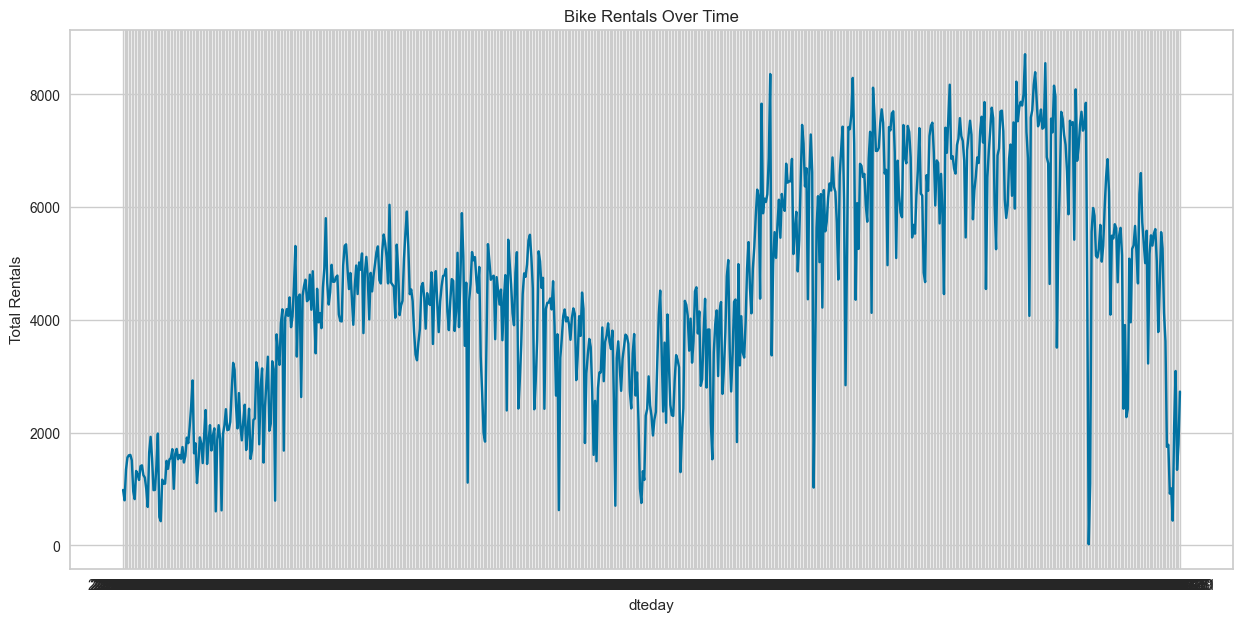

In [8]:
# Time Series Plot - Daily
plt.figure(figsize=(15, 7))
plt.plot(data.groupby('dteday')['cnt'].sum())
plt.title('Bike Rentals Over Time')
plt.xlabel('dteday')
plt.ylabel('Total Rentals')
plt.show()

Comments:
From this graph we can do several observations:
- **Trend Analysis:** The plot reveals a discernible upward trend in bike rentals over time, suggesting increasing user engagement with the bike-sharing service. This trend could be attributed to factors such as expanded service coverage, increased public awareness, or improvements in infrastructure.
- **Seasonality Observation:** There is evident seasonality in bike rentals, with periodic peaks and troughs. This pattern likely aligns with weather changes, tourist seasons, or city events.
- **Volatility Insight:** Notably, the volatility in rental numbers escalates in the second year (2012). This increase in fluctuations might be influenced by external factors such as varying weather conditions, changes in user demographics, or modifications in pricing strategies.

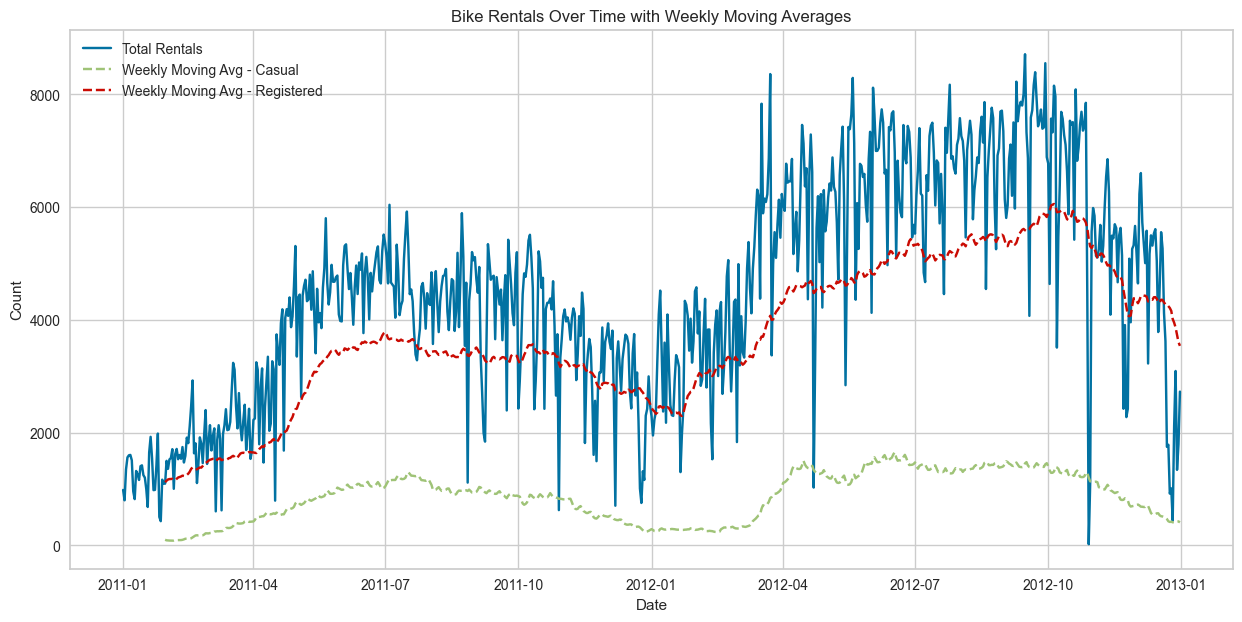

In [9]:
data['dteday'] = pd.to_datetime(data['dteday'])

# Calculate total rentals per day
total_rentals_per_day = data.groupby('dteday')['cnt'].sum()

# Calculate weekly moving average for 'casual' and 'registered'
weekly_ma_casual = data.groupby('dteday')['casual'].sum().rolling(window=30).mean()
weekly_ma_registered = data.groupby('dteday')['registered'].sum().rolling(window=30).mean()

# Plotting
plt.figure(figsize=(15, 7))

# Plot total rentals
plt.plot(total_rentals_per_day, label='Total Rentals')

# Plot weekly moving average of 'casual' and 'registered'
plt.plot(weekly_ma_casual, label='Weekly Moving Avg - Casual', linestyle='--')
plt.plot(weekly_ma_registered, label='Weekly Moving Avg - Registered', linestyle='--')

# Title and labels
plt.title('Bike Rentals Over Time with Weekly Moving Averages')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

Comments:               
- With this above chart, we extend the initial time series plot by incorporating weekly moving averages for both casual and registered users. The moving averages smooth out short-term fluctuations and provide a clearer view of long-term trends.
- **Growth Trend Confirmation:** The inclusion of moving averages confirms the growth trend in bike rentals. This sustained increase could be indicative of successful marketing strategies, enhanced service quality, or a growing preference for eco-friendly transportation among the city’s populace.
- **Economic and Business Implications:** The rising trend might also mirror the city’s economic health, where an improving economic scenario could lead to increased discretionary spending on services like bike-sharing.
- **Seasonal Patterns and User Segmentation:** The analysis underscores consistent seasonal patterns, which repeat annually. Moreover, it becomes evident that registered users primarily drive the overall rental trend. This insight is crucial for targeted marketing and service enhancement strategies, focusing more on the needs and preferences of registered users.

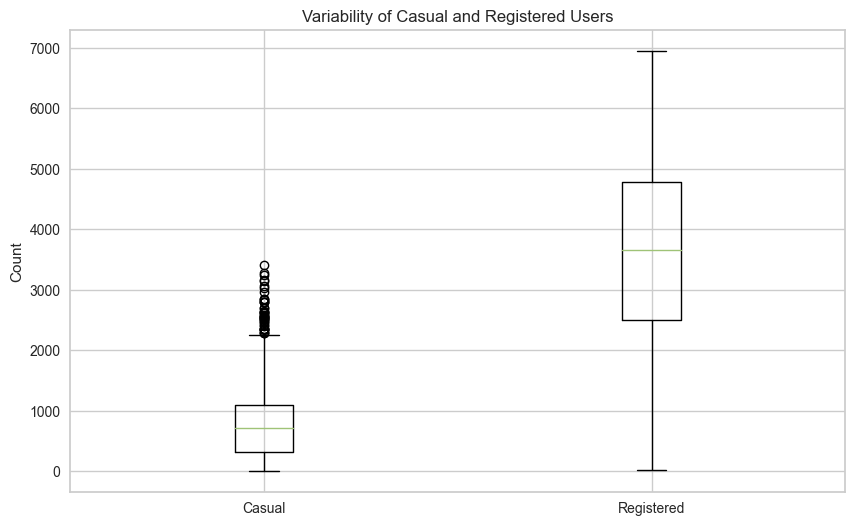

In [10]:
data['dteday'] = pd.to_datetime(data['dteday'])

# Calculate total rentals per day
total_rentals_per_day = data.groupby('dteday')['cnt'].sum()

# Calculate daily counts for 'casual' and 'registered'
daily_casual = data.groupby('dteday')['casual'].sum()
daily_registered = data.groupby('dteday')['registered'].sum()

# Calculate standard deviations
std_casual = daily_casual.std()
std_registered = daily_registered.std()

# Plotting boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([daily_casual, daily_registered], labels=['Casual', 'Registered'])
plt.title('Variability of Casual and Registered Users')
plt.ylabel('Count')
plt.show()

Comments:        
1. **Boxplot Characteristics**:
   - **Casual Users**:
     - Lower median rental count compared to registered users, indicating casual users generally rent fewer bikes on a daily basis.
     - A smaller interquartile range (IQR), which implies less variability in the daily rental counts among the majority of casual users.
     - Outliers above the boxplot indicate days with unusually high rentals for casual users, possibly due to specific events, favorable weather conditions, or seasonal tourist influx.
   - **Registered Users**: 
     - A higher median rental count, confirming adn showcasing that registered users are the primary users of the bike-sharing service on a daily basis.
     - A wider IQR, suggesting more variability in the rental behavior of registered users compared to casual users. However, the absence of significant outliers indicates that this variability is consistent and predictable. Thus, the model that will be developped will therefore be much better at providing accuracy for registered than casual.

2. **Implications for Bike-Sharing Service**:
   - **Casual Users' Behavior**: The infrequent but significant spikes in rentals (outliers) for casual users suggest that their usage might be influenced by non-routine factors. These could include leisure activities, special events, or seasonal trends. The bike-sharing service could consider targeted marketing or promotional offers during expected peak times to attract more casual renters.
   - **Registered Users' Reliability**: The consistent yet varied usage of registered users highlights their importance to the service. They provide a stable customer base with predictable rental patterns, albeit with some daily fluctuations. This consistency could be leveraged for reliable demand forecasting and operational planning.

3. **Strategic Insights**:
   - Understanding these usage patterns is vital for resource allocation, service improvement, and marketing strategies. For instance, ensuring adequate bike availability to accommodate the variable needs of both user groups.
   - Further analysis could explore the factors contributing to the high-usage days for casual users and the variability among registered users, providing more insights for targeted strategies.

This analysis provides a clear distinction between the rental behaviors of casual and registered users, which is crucial for making informed decisions to optimize the bike-sharing service.

#### 3.2 Looking for patterns:

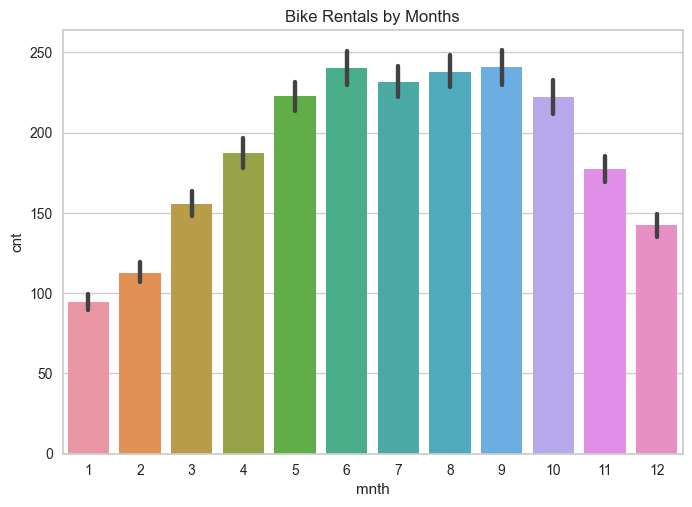

In [11]:
# Bar Plot - Monthly
sns.barplot(x='mnth', y='cnt', data=data)
plt.title('Bike Rentals by Months')
plt.show()

Comments:             
- **Seasonal Influence**: The higher level of bike rentals during spring and summer months aligns with general expectations of seasonal behavior. Warmer and more pleasant weather conditions during these seasons are conducive to outdoor activities like biking, leading to increased usage of the bike-sharing service.
- **Strategic Implications**: This seasonal trend has significant implications for resource allocation, marketing, and operational planning for the bike-sharing service. For instance, the service could plan for increased bike availability and maintenance during these peak months. Additionally, targeted marketing campaigns could be developed to maximize user engagement during these seasons.
- **Potential for Growth**: The popularity of the service during warmer months suggests an opportunity for growth. The service could explore strategies to maintain or increase usage during the less popular colder months, such as promotional offers or partnering with local events that encourage outdoor activities.
- **Understanding User Preferences**: The trend also indicates user preferences for biking in favorable weather conditions. The bike-sharing service could leverage this insight to offer weather-related promotions or updates, enhancing user experience and satisfaction.

Overall, the monthly variation in bike rentals highlights the importance of considering seasonal factors in the management and strategic planning of the bike-sharing service.

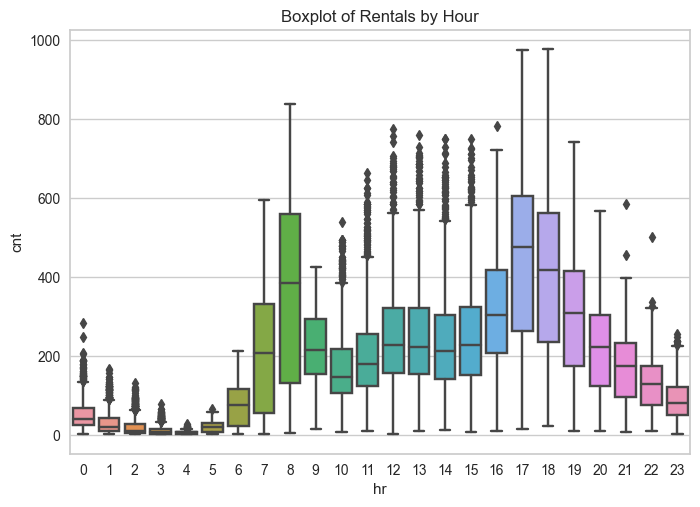

In [12]:
# Distribution of Rentals by Hour
sns.boxplot(x='hr', y='cnt', data=data)
plt.title('Boxplot of Rentals by Hour')
plt.show()

Comments:      
This chart seems to indicate that morning and late afternoon are the moments where there is the highest level of bikes rental.
- **Peak Rental Hours:** The chart likely shows higher medians and possibly wider interquartile ranges during morning and late afternoon hours. This pattern suggests these times are peak hours for bike rentals, possibly aligning with typical commuting hours for work or university/school.
- **Workday Commuting Trends:** The morning and late afternoon peaks could be indicative of a significant number of users relying on the bike-sharing service for their workday commutes.
- Outliers and Variability: We observe a lot of outliers in the moddle of the dat, these could indicate sporadic demand possibly influenced by events, weather conditions, or other non-routine factors.
- **Strategic Implications:** Understanding these hourly patterns is crucial for operational planning, such as allocating more bikes and staff during peak hours for maintenance and customer service. It also provides insights for potential pricing strategies, where differential pricing could be applied based on peak and off-peak hours.
- **Extended User Services:** The service might also consider offering additional amenities during peak hours, like enhanced customer support or streamlined rental processes, to improve user experience.

This analysis provides valuable insights into hourly rental patterns, assisting in making informed decisions to optimize service efficiency and user satisfaction.

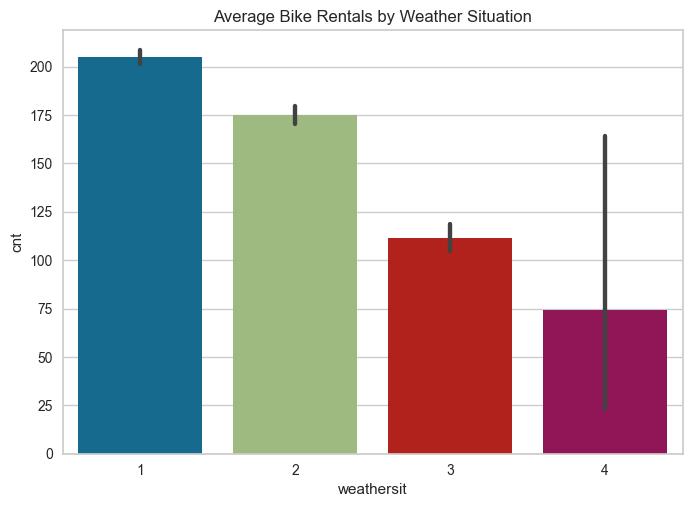

In [13]:
# Rentals by Weather Situation
sns.barplot(x='weathersit', y='cnt', data=data)
plt.title('Average Bike Rentals by Weather Situation')
plt.show()

Comments:                
When the weather is at its worst (4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog) the renting of bikes decreases a lot. 

- **Weather Impact on Rentals:** The bar plot evidently shows a decreasing trend in average bike rentals as the weather conditions worsen, from category 1 (best weather) to category 4 (worst weather).
This trend aligns with the logical assumption that more favorable weather conditions are conducive to outdoor activities like biking.
- **Strategic Implications for Bike-Sharing Services:** These insights emphasize the importance of weather considerations in the operational and strategic planning of bike-sharing services. During adverse weather conditions, the service could explore alternative strategies to maintain user engagement, such as promoting the use of bikes for shorter, necessary trips where other modes of transport might be less convenient. The service could also consider weather-based dynamic pricing or special promotions during less favorable weather to incentivize usage.

In summary, the analysis of bike rentals in relation to weather conditions provides critical insights for demand forecasting, marketing strategies, and operational adjustments to optimize service provision and user experience.

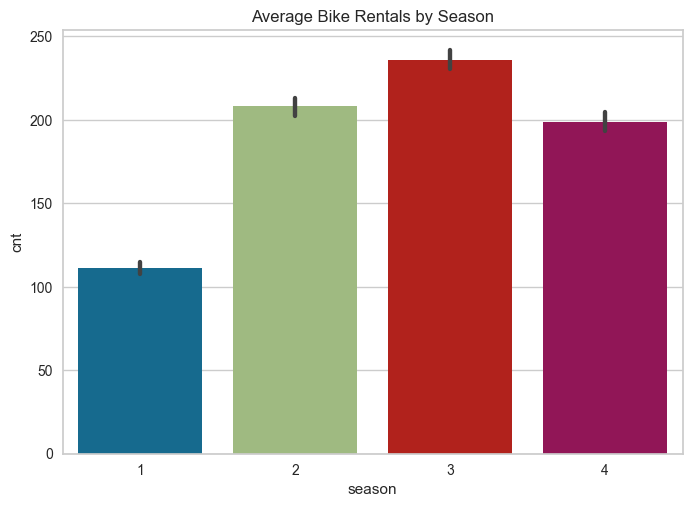

Where 1:springer, 2:summer, 3:fall, 4:winter


In [14]:
# Average Rentals per Season
sns.barplot(x='season', y='cnt', data=data)
plt.title('Average Bike Rentals by Season')
plt.show()
print("Where 1:springer, 2:summer, 3:fall, 4:winter")

Comments: 
This graph is very surprising because we can see that spring (category 1) is the one that counts the lowest amount of bike shares. This seems to be an error.

In [15]:
#Let's List Months for Each Season
seasons = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
months_in_season = {season: data[data['season'] == season]['mnth'].unique().tolist() for season in seasons}

for season, months in months_in_season.items():
    print(f"The months in {seasons[season]} are: {months}")

The months in Spring are: [1, 2, 3, 12]
The months in Summer are: [3, 4, 5, 6]
The months in Fall are: [6, 7, 8, 9]
The months in Winter are: [9, 10, 11, 12]


Comments:                    
Indeed, the previous graph was showcasing an error. It seems that the months that were mapped with the season are not correct.      
However since the seasons seems to have an impact on the bike rentals it is important to take this aspect into consideration while selecting varaibles for the model. There are therefore 2 options, relying solely on months or recoding season so that it is correct. Eventually, we belive that hvaing season and month together is not useful since one is the aggregation of the other. Therefore, we will opt with the option of dropping season and relying on months to capture the trend over the year. 

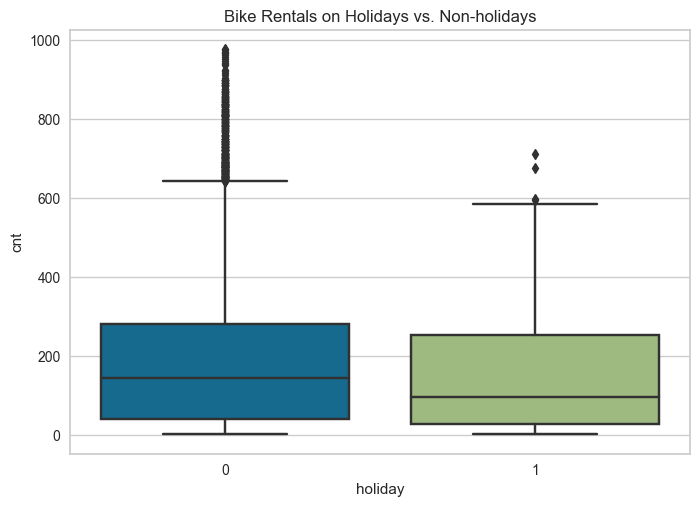

Where 1 is holiday and 0 is not holiday.


In [16]:
# Impact of Holidays on Rentals
sns.boxplot(x='holiday', y='cnt', data=data)
plt.title('Bike Rentals on Holidays vs. Non-holidays')
plt.show()
print("Where 1 is holiday and 0 is not holiday.")

Comment:   
From the above graph, it seems that there is not a big difference between the number of bikes used during holday days and working days.     
This indicates that this variable probably does not hold a lot of explainability when it comes to expalining our target variable: the number of bikes.

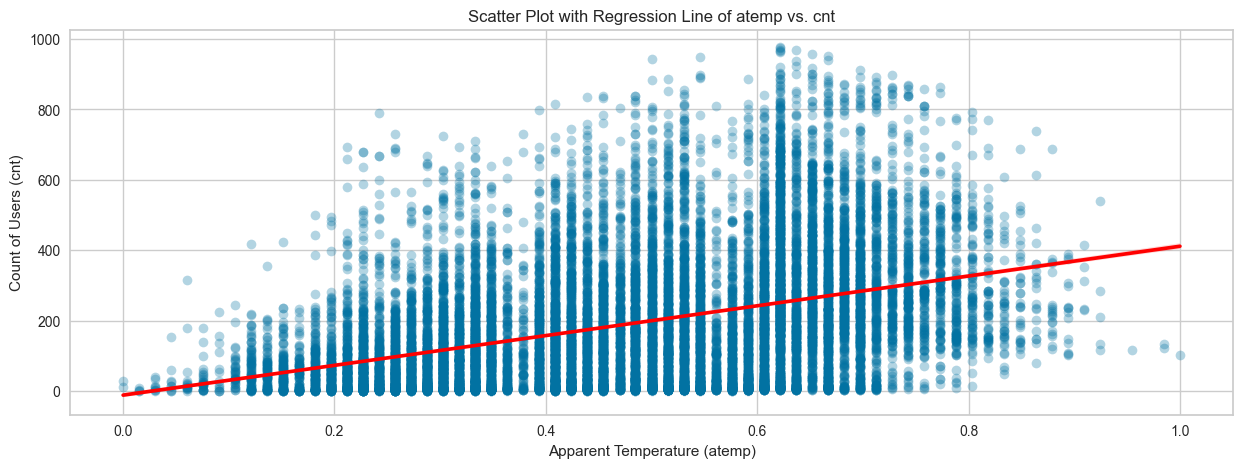

In [17]:
#Looking into temperature:
plt.figure(figsize=(15, 5))
sns.regplot(x='atemp', y='cnt', data=data, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})

plt.title('Scatter Plot with Regression Line of atemp vs. cnt')
plt.xlabel('Apparent Temperature (atemp)')
plt.ylabel('Count of Users (cnt)')

plt.show()

Comments:      
    - The increasing trend of the regression line indicates a positive correlation between the apparent temperature and the number of users. This suggests that as the temperature becomes more comfortable (neither too hot nor too cold), more people are inclined to use the bike-sharing service. Therefore, this indicates this variable might be of importance in order to predict the number of bikes required.           
    - However the widespread distribution of points uggests other factors are also influencing rental counts.

#### 3.3 Looking for Client segmentations:

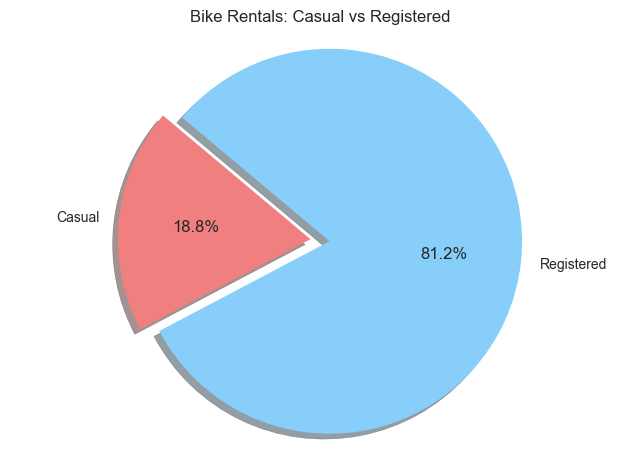

In [18]:
# Sum of casual and registered rentals
casual_sum = data['casual'].sum()
registered_sum = data['registered'].sum()

# Pie chart
labels = 'Casual', 'Registered'
sizes = [casual_sum, registered_sum]
colors = ['lightcoral', 'lightskyblue']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e., 'Registered')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Bike Rentals: Casual vs Registered')
plt.show()

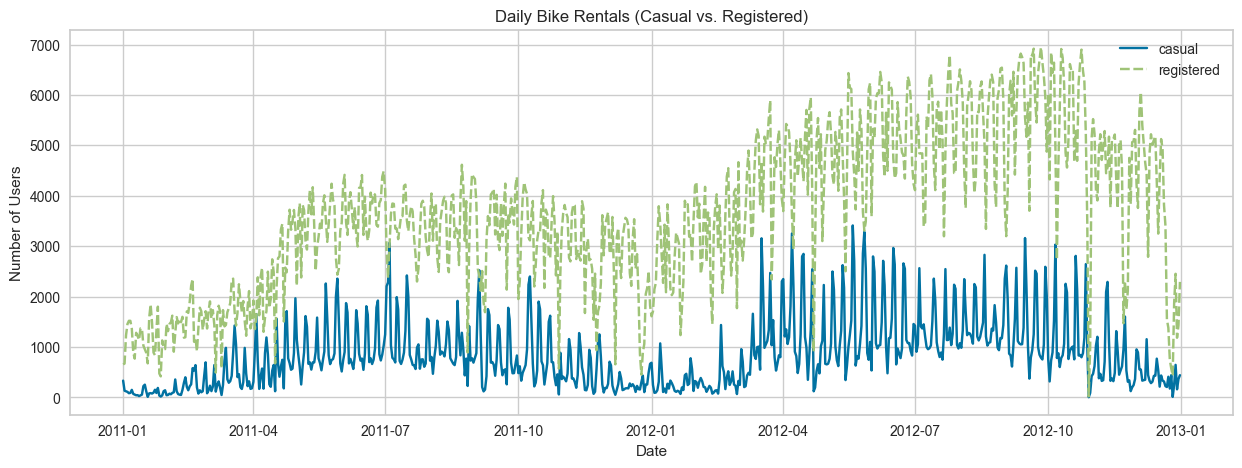

In [19]:
# Time Series Plot of Daily Bike Usage
data['dteday'] = pd.to_datetime(data['dteday'])
daily_data = data.groupby('dteday').agg({'casual': 'sum', 'registered': 'sum'})
plt.figure(figsize=(15, 5))
sns.lineplot(data=daily_data)
plt.title('Daily Bike Rentals (Casual vs. Registered)')
plt.ylabel('Number of Users')
plt.xlabel('Date')
plt.show()

Comments:     
These visualizations further confirm and illustrate our initial interpretation from the summary statistics: Registered clients constitute the majority of the bike rental service's clientele, representing over 80% of total rentals. The pie chart distinctly showcases this disparity, where casual clients account for a significantly smaller proportion of the overall client base. This predominant presence of registered users underscores their importance to the bike-sharing service's operations and success.

Additionally, the time series plot of daily bike rentals offers deeper insights into the differing usage patterns between casual and registered users. By observing the trends and fluctuations in daily rentals over time, we can begin to understand the distinct habits and preferences of these two user categories. This analysis not only highlights the consistent and dominant usage by registered users but also provides an opportunity to explore the factors influencing casual users' rental patterns. Understanding these differences is crucial for tailoring the bike-sharing service to meet the diverse needs of both casual and registered users, optimizing service delivery, and enhancing overall user satisfaction. 

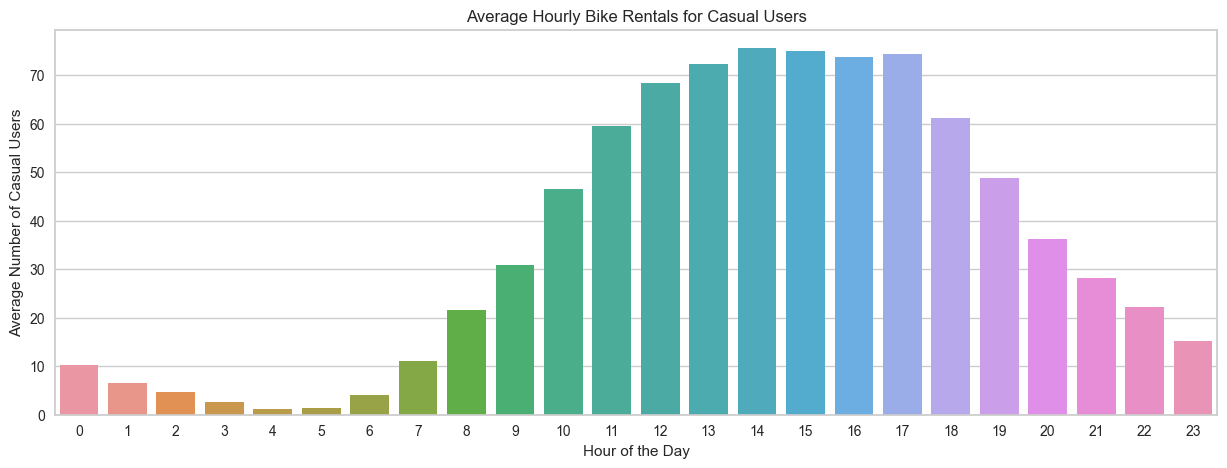

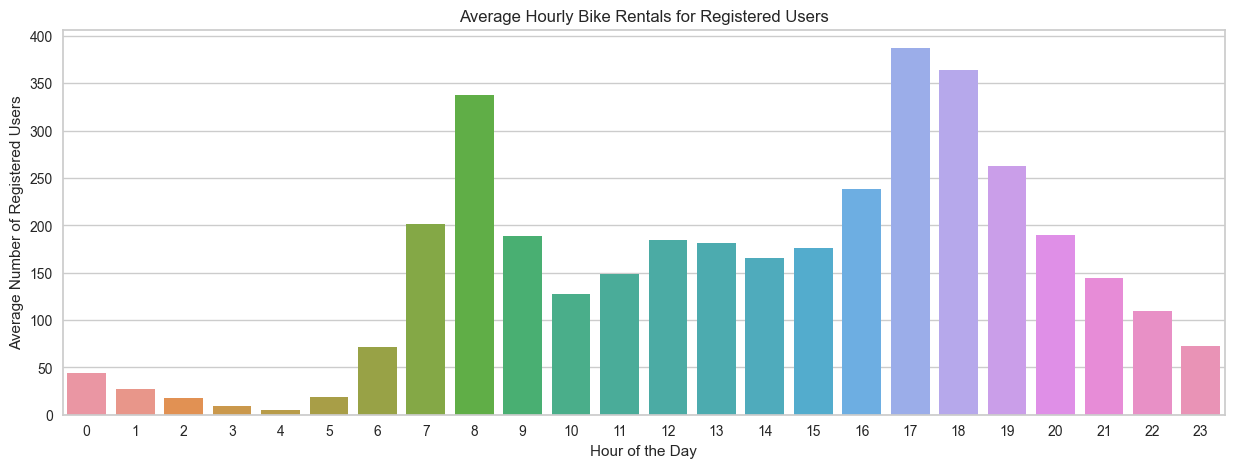

In [20]:
# Hourly Usage Patterns for Casual Users
plt.figure(figsize=(15, 5))
sns.barplot(x='hr', y='casual', data=data, ci=None)
plt.title('Average Hourly Bike Rentals for Casual Users')
plt.ylabel('Average Number of Casual Users')
plt.xlabel('Hour of the Day')
plt.show()

# Hourly Usage Patterns for Registered Users
plt.figure(figsize=(15, 5))
sns.barplot(x='hr', y='registered', data=data, ci=None)
plt.title('Average Hourly Bike Rentals for Registered Users')
plt.ylabel('Average Number of Registered Users')
plt.xlabel('Hour of the Day')
plt.show()

Comment/Interpretation:       
- **Distinct Usage Patterns**:
   - The two graphs distinctly highlight the differences in hourly bike rental habits between registered and casual users. This differentiation is key to understanding the varied needs and preferences of the service's user base.
- **Registered Users**:
   - Registered clients exhibit peak rental times in the early morning and late afternoon. This pattern is indicative of commuting behavior, suggesting that registered users primarily use the bike-sharing service for transportation to and from work or educational institutions.
- **Casual Users**:
   - Casual users show a different trend, with a significant peak in rentals from mid-morning to late afternoon (approximately 10 AM to 5 PM). This usage pattern aligns more with leisure activities or tourism, implying that casual users are likely to rent bikes for city exploration or recreational purposes during their free time.
- **Implications for Service Planning**:
   - Understanding these divergent patterns is crucial for operational planning and marketing strategies. For registered users, ensuring bike availability during peak commuting hours is essential, along with potentially offering incentives for consistent use.
   - For casual users, focusing on accessibility and convenience during midday hours could enhance their experience. Marketing strategies could target tourists and leisure seekers, highlighting popular routes or destinations in the city.
   
In summary, the distinct hourly rental patterns of casual and registered users provide valuable insights into their respective usage motivations and preferences, enabling more targeted and effective service provision and marketing efforts by the bike-sharing company.

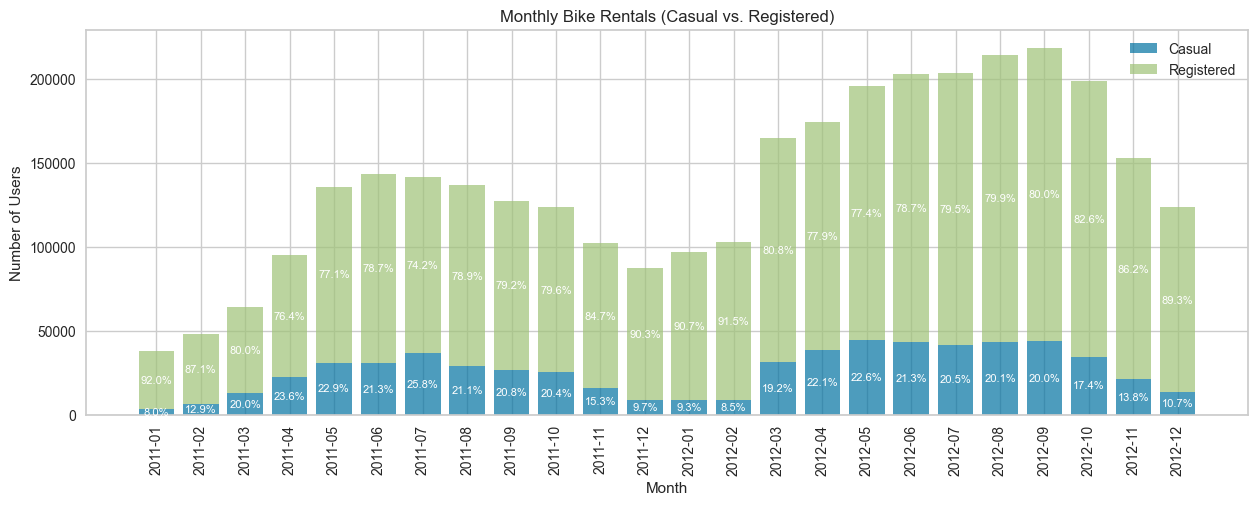

In [21]:
monthly_data = data.groupby(data['dteday'].dt.to_period("M")).agg({'casual': 'sum', 'registered': 'sum'})

# Calculate the percentage for each component
total = monthly_data['casual'] + monthly_data['registered']
percentage_casual = monthly_data['casual'] / total * 100
percentage_registered = monthly_data['registered'] / total * 100

# Create a stacked bar chart
plt.figure(figsize=(15, 5))
p1 = plt.bar(monthly_data.index.astype(str), monthly_data['casual'], label='Casual', alpha=0.7)
p2 = plt.bar(monthly_data.index.astype(str), monthly_data['registered'], bottom=monthly_data['casual'], label='Registered', alpha=0.7)

# Add percentage labels
for i, (casual, registered) in enumerate(zip(monthly_data['casual'], monthly_data['registered'])):
    plt.text(i, casual / 2, f'{percentage_casual.iloc[i]:.1f}%', ha='center', va='center', color='white', fontsize=8)
    plt.text(i, casual + registered / 2, f'{percentage_registered.iloc[i]:.1f}%', ha='center', va='center', color='white', fontsize=8)

plt.title('Monthly Bike Rentals (Casual vs. Registered)')
plt.ylabel('Number of Users')
plt.xlabel('Month')

# Rotate x-axis labels vertically
plt.xticks(rotation='vertical')

plt.legend()
plt.show()

Comments:     
- **Seasonal Trends:** The graph clearly illustrates the fluctuation in the number of casual and registered users on a month-to-month basis. This visualization provides a comprehensive view of how user behavior changes with the seasons.
- **Casual Users' Seasonal Preference:** A notable increase in the percentage of casual users during warmer months is evident. This trend likely aligns with tourist seasons and favorable weather conditions that encourage outdoor activities, including biking. The higher proportion of casual rentals in these months suggests that the bike-sharing service is particularly popular among tourists and individuals engaging in recreational activities during this period.
- **Registered Users' Consistency:** In contrast, registered users appear to have a more consistent usage pattern throughout the year. This consistency indicates a reliance on the service for regular commuting or daily activities, regardless of the season. 

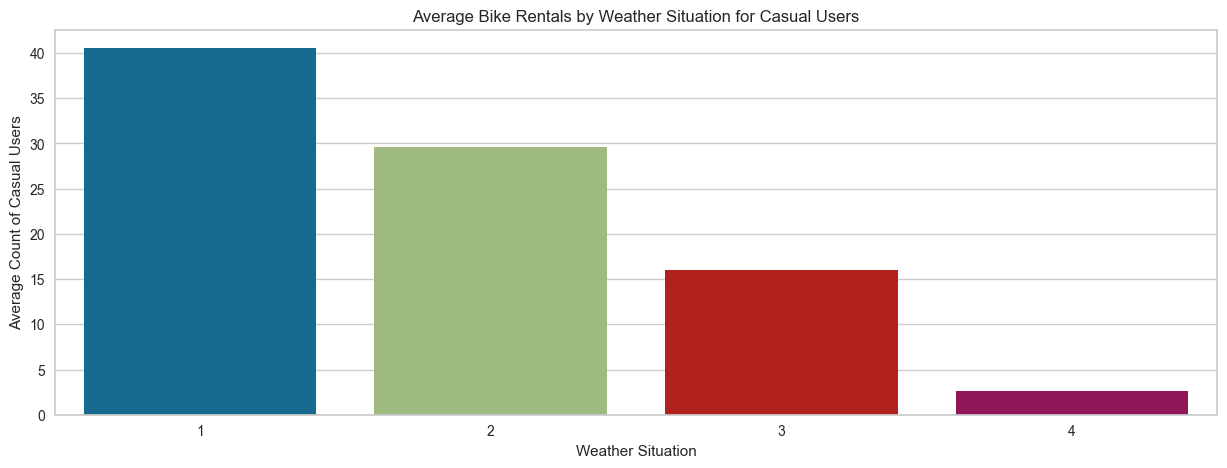

In [22]:
# Group the data by 'weathersit' and calculate the mean for 'casual'
weather_casual_mean = data.groupby('weathersit')['casual'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(15, 5))
sns.barplot(x='weathersit', y='casual', data=weather_casual_mean)
plt.title('Average Bike Rentals by Weather Situation for Casual Users')
plt.ylabel('Average Count of Casual Users')
plt.xlabel('Weather Situation')
plt.show()

Reminder:     
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy         
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist       
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds          
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog       
    
Comments:      
This chart confirms the intuition from the previous graph, casual users are mainly present when the weather is at its best.

#### 3.4: Text and Date Features Analysis:

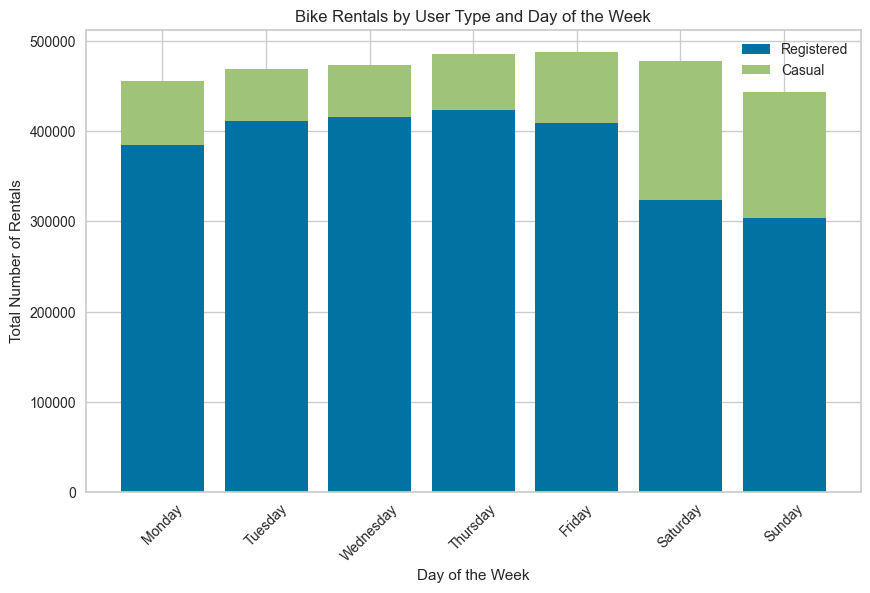

In [23]:
data['weekday_name'] = data['dteday'].dt.day_name()

# Assuming 'data' has 'casual' and 'registered' columns and 'weekday_name' is already created
# Group the data by 'weekday_name' and calculate the sum for 'casual' and 'registered'
weekday_totals = data.groupby('weekday_name').agg({'casual': 'sum', 'registered': 'sum'}).reset_index()

# Sort the dataframe by the days of the week assuming the days are not in order
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_totals['weekday_name'] = pd.Categorical(weekday_totals['weekday_name'], categories=ordered_days, ordered=True)
weekday_totals.sort_values('weekday_name', inplace=True)

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(weekday_totals['weekday_name'], weekday_totals['registered'], label='Registered')
plt.bar(weekday_totals['weekday_name'], weekday_totals['casual'], bottom=weekday_totals['registered'], label='Casual')
plt.title('Bike Rentals by User Type and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Number of Rentals')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Comments/Interpretations:     
- **Stability in Total Rentals During the Week:** The graph suggests that the total number of bike rentals remains relatively stable across most weekdays (Monday through Saturday). This indicates a consistent user demand for the bike-sharing service during these days.
- **Variation on Sundays:** A noticeable difference in rental patterns on Sundays could be observed, which might reflect a change in the population's routine or availability on the last day of the weekend.
- **Weekend Trends for User Types:** The increase in casual rentals and the corresponding decrease in registered rentals during weekends (particularly on Saturday and Sunday) are significant. This trend likely confirms the idea of differing usage patterns between casual and registered users:
    - Casual Users: The rise in casual rentals during weekends indicates that these users might be more recreational or leisure-oriented, possibly tourists or local residents using the service for non-commuting purposes.
    - Registered Users: The decrease in registered rentals on weekends could indicate that these users primarily use the service for commuting purposes on weekdays. The lower usage on weekends might reflect a break from their regular work or educational routines.

### 4. Outliers Analysis:

In [24]:
Q1 = data['cnt'].quantile(0.25)
Q3 = data['cnt'].quantile(0.75)
IQR = Q3 - Q1

# Defining what is an outlier
outlier_condition = ((data['cnt'] < (Q1 - 1.5 * IQR)) | (data['cnt'] > (Q3 + 1.5 * IQR)))

# Counting outliers
outliers = data[outlier_condition]
num_outliers = outliers.shape[0]
total_count = data['cnt'].count()

# Percentage of data points that are outliers
outlier_percentage = (num_outliers / total_count) * 100

print(f"Overall the database contains {num_outliers} Outliers.")
print(f"This represents around {outlier_percentage:.2f}% of the whole database.")

Overall the database contains 505 Outliers.
This represents around 2.91% of the whole database.


Let's store all the outliers in a dataframe in order to better analyse them:

In [25]:
# Creating a DataFrame of outliers
outliers_df = data[outlier_condition].copy()

outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 5536 to 17077
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       505 non-null    int64         
 1   dteday        505 non-null    datetime64[ns]
 2   season        505 non-null    int64         
 3   yr            505 non-null    int64         
 4   mnth          505 non-null    int64         
 5   hr            505 non-null    int64         
 6   holiday       505 non-null    int64         
 7   weekday       505 non-null    int64         
 8   workingday    505 non-null    int64         
 9   weathersit    505 non-null    int64         
 10  temp          505 non-null    float64       
 11  atemp         505 non-null    float64       
 12  hum           505 non-null    float64       
 13  windspeed     505 non-null    float64       
 14  casual        505 non-null    int64         
 15  registered    505 non-null    int64

In [27]:
# exporting dataframe for streamlit
outliers_df.to_csv('outliers_data.csv', index=False)

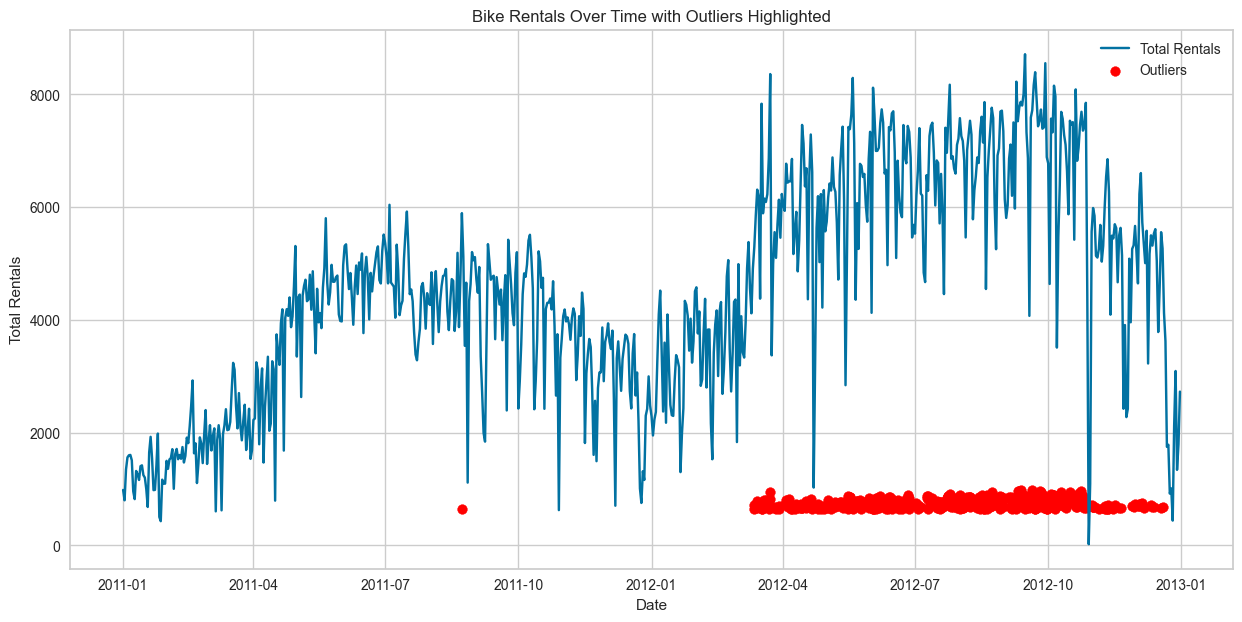

In [26]:
plt.figure(figsize=(15, 7))
plt.plot(data.groupby('dteday')['cnt'].sum(), label='Total Rentals')
plt.scatter(outliers_df['dteday'], outliers_df['cnt'], color='red', label='Outliers')
plt.title('Bike Rentals Over Time with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

Comments:       
From this graph we can see that most of the outliers are in the second year (2012).         
Now that we know in which year they are happenin, we would like to deepen the analysis and understand if there is a behaviour behind these outliers or not.
First of all we will try to understand *when* these outliers happen: at what time, on which day and in which month.
Then we will look at any correlation with other variables, such as weather or temperature.

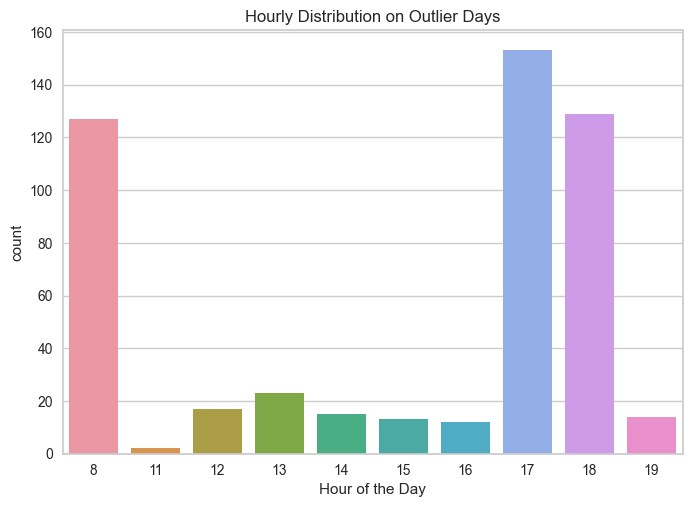

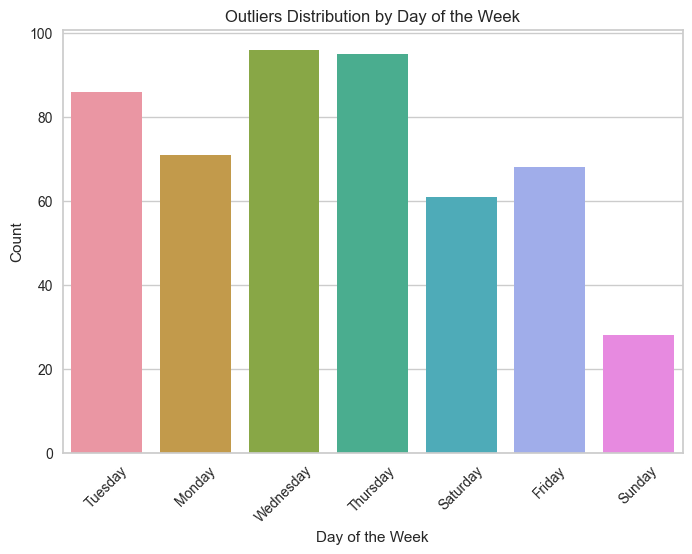

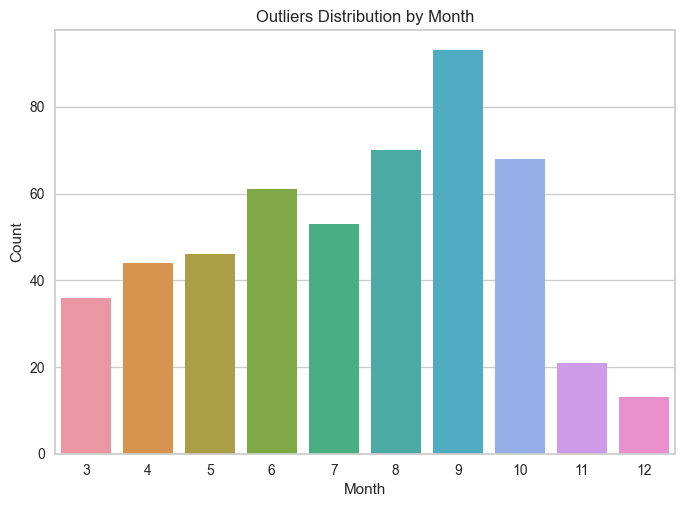

In [27]:
#Looking into hours:
sns.countplot(x='hr', data=outliers_df)
plt.title('Hourly Distribution on Outlier Days')
plt.xlabel('Hour of the Day')
plt.show()

#Looing into weekdays
sns.countplot(x='weekday_name', data=outliers_df)
plt.title('Outliers Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#Looking at months
sns.countplot(x='mnth', data=outliers_df)
plt.title('Outliers Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Comment:      
- **Commuter Influence on Peak Hours:** The graph's pronounced peaks at 8 AM, 17 PM (5 PM), and 18 PM (6 PM) suggest a strong commuter influence on bike rentals during these hours on outlier days.
This pattern is indicative of a significant number of users relying on the bike-sharing service for their morning and evening commutes. The spikes at these specific hours align with typical workday start and end times, reinforcing the idea that a substantial portion of the demand on outlier days is driven by commuters. This insight can be particularly useful for tailoring service availability and marketing strategies to cater to the needs of commuting users, ensuring that there are sufficient bikes available during these critical hours of the day.
- **Midweek Outliers:** The graphs indicate a significant occurrence of outliers during the middle of the week. This trend is likely linked to registered clients, suggesting their substantial role in midweek rental spikes. The midweek surge could be due to commuting or routine usage by these regular users.
- **Seasonal Variation:** There's a noticeable concentration of outliers in warmer months, specifically in spring and summer. This increase aligns with the general preference for outdoor activities in favorable weather, attracting both casual and registered users.
- **Peak Demand Correlation:** The combination of midweek days and hotter months seems to create peak demand scenarios, leading to these outlier occurrences.

It reflects a heightened demand for bikes that surpasses usual expectations during these specific times.

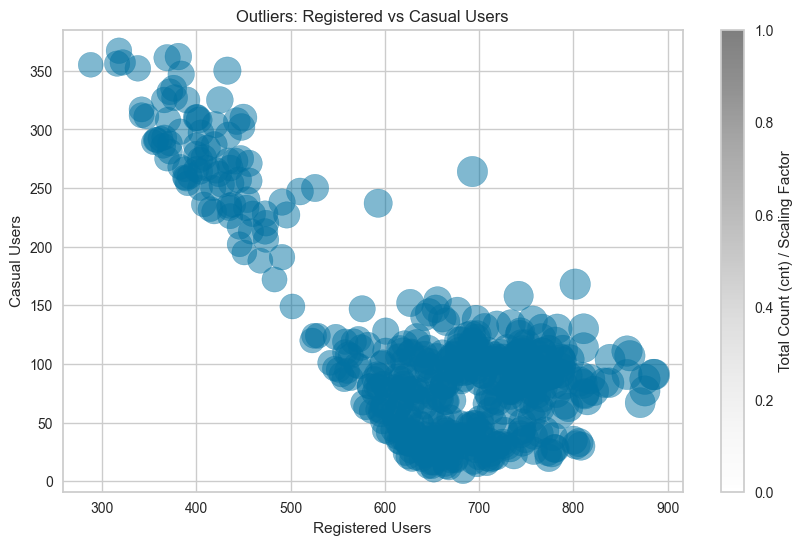

In [28]:
plt.figure(figsize=(10, 6))

# Scaling factor for the size of the dots
scaling_factor = 2  # You can adjust this value as needed

# Scatter plot with 'registered' on x-axis, 'casual' on y-axis, and scaled 'cnt' as size
plt.scatter(outliers['registered'], outliers['casual'], s=outliers['cnt'] / scaling_factor, alpha=0.5)

plt.title('Outliers: Registered vs Casual Users')
plt.xlabel('Registered Users')
plt.ylabel('Casual Users')
plt.colorbar(label='Total Count (cnt) / Scaling Factor')
plt.show()

Comments:      
    With this graph, we can confirm the previous hypothesis, that most outliers are related to registered users.

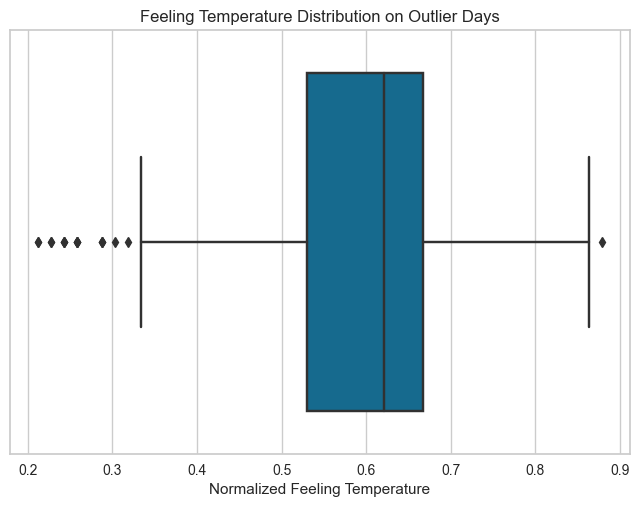

In [29]:
sns.boxplot(x='atemp', data=outliers_df)
plt.title('Feeling Temperature Distribution on Outlier Days')
plt.xlabel('Normalized Feeling Temperature')
plt.show()

Comments:      
- From the above graph we can see taht the outliers are concentrated around 0.6. 0.6 atemp refers to around 15.5 degrees. 
- **Implications of Temperature on Bike Rentals:** The concentration of outliers around this temperature range suggests a strong relationship between pleasant weather conditions and unusually high or low bike rental numbers. On days with such temperate conditions, people are more likely to engage in outdoor activities, potentially leading to spikes in bike rentals.
- **Analysis of Outlier Behavior:** The outliers in bike rental data on days with moderate temperatures might reflect exceptional events or circumstances, such as public holidays, special events, or seasonal changes that coincide with favorable weather conditions. It's also possible that days with such temperatures might see increased casual user activity, as tourists and leisure riders take advantage of the pleasant weather

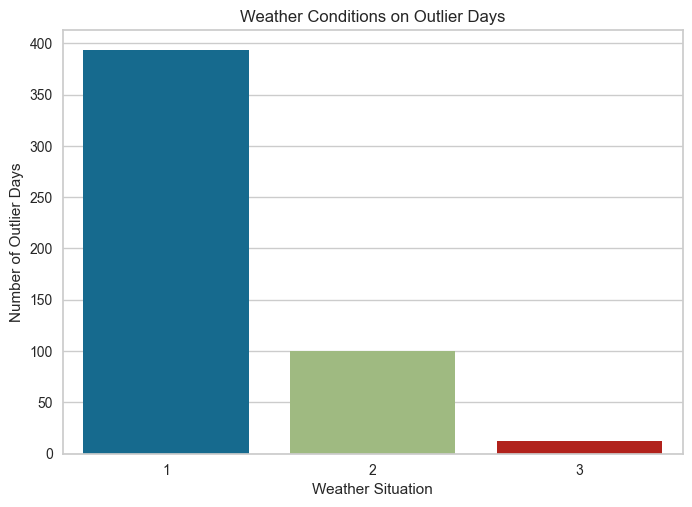

In [30]:
sns.countplot(x='weathersit', data=outliers_df)
plt.title('Weather Conditions on Outlier Days')
plt.xlabel('Weather Situation')
plt.ylabel('Number of Outlier Days')
plt.show()

Comments:       
    From this graph we can confirm the first observation and see that, as expected, most of the outliers are related to the good weather situations. 

**Overall Comment on Outlier Analysis:**
- The comprehensive analysis of outliers in our dataset has provided valuable insights into their occurrence and underlying patterns. Contrary to initial assumptions, these outliers are not random but are closely linked to periods of high demand for bikes. Key observations include a notable increase in bike rentals during specific hours, particularly in the morning and late afternoon, which aligns with commuter patterns. Moreover, the analysis revealed distinct usage spikes on certain days of the week and during warmer months, suggesting seasonal and weekly trends in user behavior.
- These patterns indicate that the outliers represent significant and predictable deviations in bike rental demand, rather than being mere anomalies. Such information is critical in understanding the full spectrum of user behavior and demand dynamics. Given their relevance and the insights they provide, it is prudent to retain these outliers in the dataset for model training. Their inclusion will likely enhance the model's ability to accurately reflect and predict real-world bike rental patterns, especially during peak demand periods. In essence, these outliers are not just noise in the data; they are pivotal in capturing the complexity and variability of bike-sharing usage, thereby facilitating more robust and reliable predictive modeling."

### 5. Features Engineering: 

#### 5.1 Creation of new variables:

Let's create some new features that we believe could be relevant for our analysis. In particular we would like to look into part of days (by binning the hours of a day and create the feature weekend.

In [31]:
data['day_part'] = pd.cut(data['hr'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

In [32]:
data['is_weekend'] = data['weekday'].isin([0, 6]).astype(int)

Since we observed an upward trend from the first year to another and a certain seasonality it would be interesting to have an additional variable that could captute these seasonal trend.
In order to try and incorporate the time series aspect of the problem in the model we decided to perform a 3h moving average. Indeed moving average have the advantage of:
- **Smoothing Fluctuations:** It smooths short-term fluctuations, clarifying underlying trends in bike rental data.
- **Capturing Recent Trends:** The 3-hour window is optimal for reflecting recent rental patterns, important for short-term predictions, which is what we want to do. 
- **Balanced Approach:** This duration offers a balanced view, responsive to changes yet stable enough to avoid anomalies' influence. 

In [33]:
# Calculate a 3-hour moving average
data['3_hour_moving_avg'] = data['cnt'].rolling(window=3).mean()

In [34]:
# Fill null values with forward fill
data['3_hour_moving_avg'] = data['3_hour_moving_avg'].fillna(method='ffill')

# If forward fill doesn't work because the first values are still null, you can fill with a constant
data['3_hour_moving_avg'] = data['3_hour_moving_avg'].fillna(data['3_hour_moving_avg'].mean())

However, it is important to note that this variable can only be used if the company has available real-time data when doing the predictions.

#### 5.2 One-Hot-Encoding Catorical Variables:    

The One-Hot-Encoding  will be realised later on when setting the model with PyCaret.

#### 5.3: Dealing with Nominal Variables *mnth* and *hr*:

In order to understand how to tackle the variables *mnth* and *hr*, it is important to understand if there is a linear realtionship between these two variables and the target variable.

Looking into the variable Hour
Correlation Coefficient between 'hr' and 'cnt': 0.39407149778294326


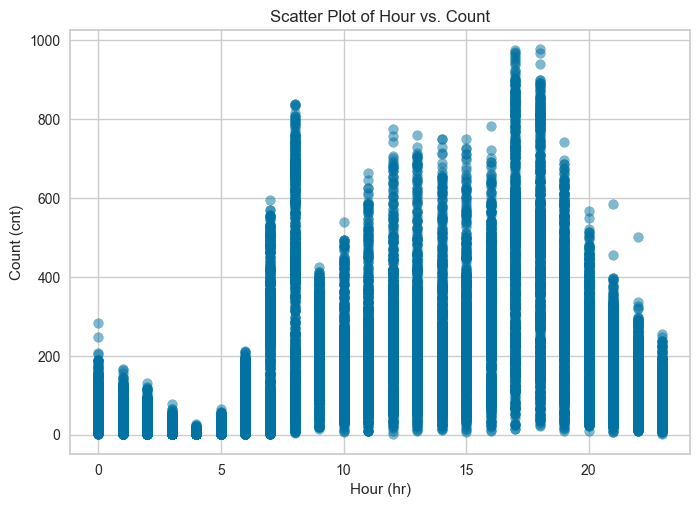

In [35]:
print("Looking into the variable Hour")
# Scatter plot
plt.scatter(data['hr'], data['cnt'], alpha=0.5)
plt.xlabel('Hour (hr)')
plt.ylabel('Count (cnt)')
plt.title('Scatter Plot of Hour vs. Count')

# Calculate and print the correlation coefficient
correlation_coefficient = data['hr'].corr(data['cnt'])
print(f"Correlation Coefficient between 'hr' and 'cnt': {correlation_coefficient}")

# Show the plot
plt.show()

Looking into the variable Month
Correlation Coefficient between 'mnth' and 'cnt': 0.12063776021315227


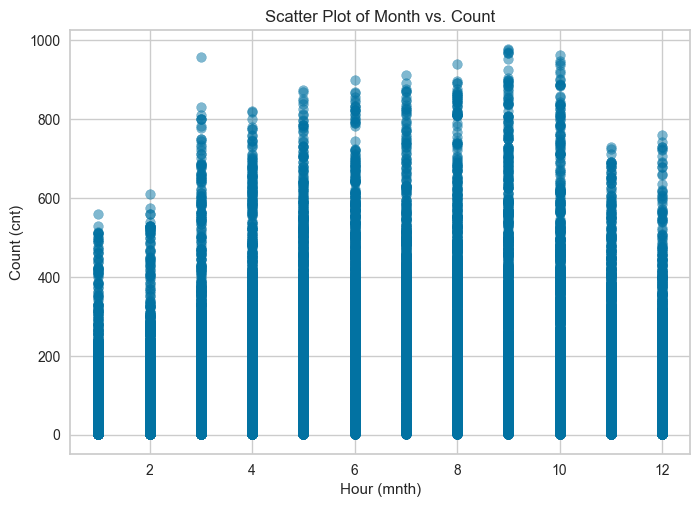

In [36]:
print("Looking into the variable Month")
# Scatter plot
plt.scatter(data['mnth'], data['cnt'], alpha=0.5)
plt.xlabel('Hour (mnth)')
plt.ylabel('Count (cnt)')
plt.title('Scatter Plot of Month vs. Count')

# Calculate and print the correlation coefficient
correlation_coefficient = data['mnth'].corr(data['cnt'])
print(f"Correlation Coefficient between 'mnth' and 'cnt': {correlation_coefficient}")

# Show the plot
plt.show()

Interpretation:   
- Hour Analysis: Correlation Coefficient of 0.39:            
    - A correlation coefficient of 0.39 suggests a moderate positive linear relationship between 'hr' and 'cnt'.
    - The positive sign still indicates that as the 'hr' variable increases, the 'cnt' variable tends to increase, and the relationship is stronger than in the previous case. 
    - The value of 0.39, while not extremely strong, indicates a moderate linear association between the two variables.
- Month Analysis: Correlation Coefficient of 0.12:            
    - A correlation coefficient of 0.12 suggests a weak positive linear relationship between 'hr' and 'cnt'.
    - The positive sign indicates that as the 'hr' variable increases, the 'cnt' variable tends to increase slightly, but the relationship is not strong.
    - The value of 0.12, being close to 0, suggests that the correlation is relatively weak.

In both cases the linear realtionship is not enough to leave the variable as they are. One day of dealing with this issue is by using sine and cosine. Indeed, using the sine and cosine of time-related variables, such as 'hr' (hour) in a regression machine learning problem, can be beneficial for several reasons:
1. **Cyclic Nature**: Time-related variables like 'hr' are often cyclic, repeating themselves in a predictable pattern (e.g., 24 hours in a day). Sine and cosine functions naturally capture this cyclic behavior, as they oscillate between -1 and 1 over a period.
2. **Continuity**: Sine and cosine transformations ensure continuity in the representation of time, preventing abrupt jumps from 23 to 0 hours, for example, which can be problematic in linear models. This continuity aids in modeling smooth transitions.
3. **Orthogonality**: Sine and cosine functions are orthogonal, meaning they are uncorrelated with each other. By using both sine and cosine of a time-related variable, we can capture variations in amplitude (sine) and phase (cosine), providing a richer representation of the cyclic pattern.
4. **Linearity**: Linear regression models and many other regression techniques assume linearity in the input features. Sine and cosine transformations can often approximate the underlying cyclic patterns in a more linear fashion, making the modeling process more tractable and interpretable.
5. **Interpretability**: Using sine and cosine allows to interpret the coefficients more intuitively. For example, a positive coefficient for the sine component indicates an increase in the outcome as the cyclic pattern increases, and vice versa.

In summary, representing time-related variables like 'hr' using sine and cosine functions can help capture their cyclic nature, ensure continuity, maintain orthogonality, achieve a more linear representation, and enhance interpretability. This can lead to improved model performance and a better understanding of the underlying patterns in regression tasks involving time-related features.

We performed the sine and cosine of both *'hr'* and *'mnth'* however the different models we ran made us realised that the features that sine and cosine offer (described above) were not useful in our case when dealing with the variable *'mnth'*.
Indeed, the usage of bikes can vary significantly from month to month due to seasonal changes or weather conditions as we saw in the data anlysis part. Thus, in our opinion, treating month as a categorical feature is more appropriate. This will allow the model to capture unique patterns in bike usage for each month without assuming a linear relationship between them.

In [37]:
# Sine and cosine transformations for 'hr'
data['hr_sin'] = np.sin(data['hr'] * (2. * np.pi / 24))
data['hr_cos'] = np.cos(data['hr'] * (2. * np.pi / 24))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   instant            17379 non-null  int64         
 1   dteday             17379 non-null  datetime64[ns]
 2   season             17379 non-null  int64         
 3   yr                 17379 non-null  int64         
 4   mnth               17379 non-null  int64         
 5   hr                 17379 non-null  int64         
 6   holiday            17379 non-null  int64         
 7   weekday            17379 non-null  int64         
 8   workingday         17379 non-null  int64         
 9   weathersit         17379 non-null  int64         
 10  temp               17379 non-null  float64       
 11  atemp              17379 non-null  float64       
 12  hum                17379 non-null  float64       
 13  windspeed          17379 non-null  float64       
 14  casual

### 6. Correlation Analysis:

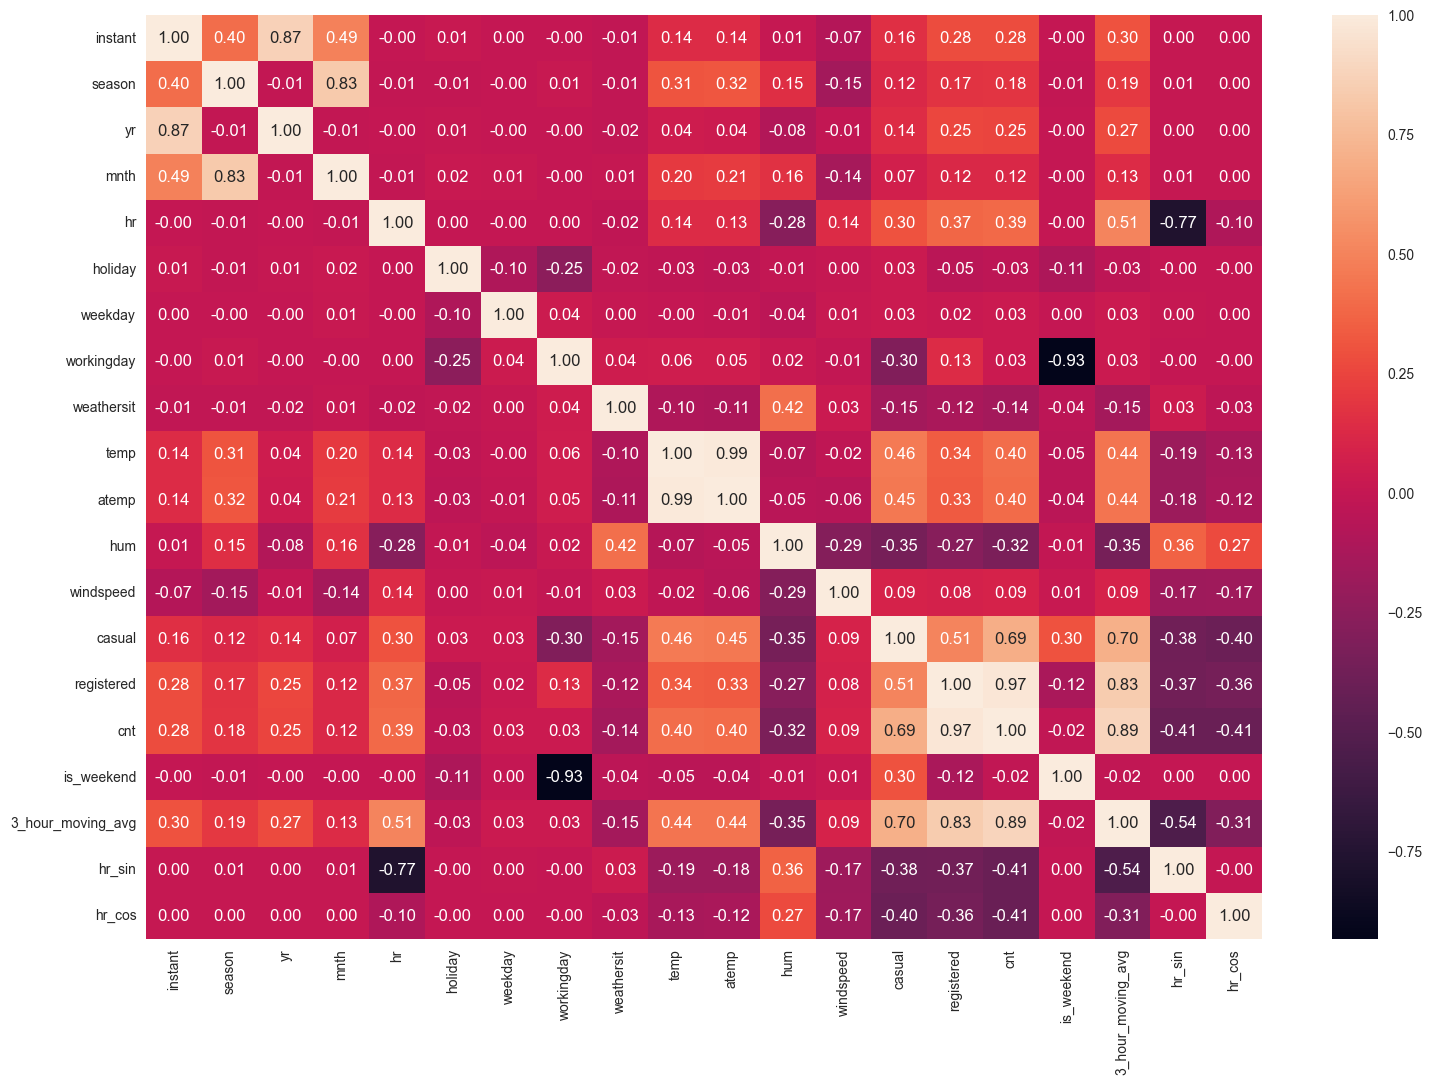

In [38]:
correlation_matrix = data.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

Comments/Interpretation - From the above correlation we can conclude the following:         
Related to the correlation with the target variable *'cnt'*:        
    - the variables *'holiday'* and *'working day'* have a 0.03 correlation with target variable. This means they bring nearly no explaninability to the target variable. This confirms the intuition from the previous analysis from the data visulization part. Therefore we can remove them and not include them in the model.         
    - let's not that the variable *'windspeed'* also has a low correlation with the target variable but our understanding of the problem make us believe that it is an important factor to take into in order to forecast accurately the target variable. 
    - the variable we created *is_weekend* does not seem to have a big explainability of our target variable either, since it has a very low correlation of 0.02. We will also delete it.

Related to the correlation between the different variables:       
    - *'temp'* and *'atemp'* are highly correlated, this means that they are nearly identical. Therefore, we should remove one of them. From research it seems that *'atemp'* is slightly more relevant because it includes the effects of humidity, wind speed, and the actual temperature. Therefore we will drop *'temp'*.             
    - *'month'* and *'season'* are also highly correlated. Since we have seen that the mapping of the seasons is not correct, we can decide to remove the variable *'season'*.
    - *'hr_sin'* and *'hr'* are highly correlated, as expected. Since *'hr_sin'* has more explainability towards the target variable and for the previous reasons mentioned before. We will drop *'hr'*.

### 7. Data Cleaning:

#### 7.1: Result from Correlation Analysis:

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   instant            17379 non-null  int64         
 1   dteday             17379 non-null  datetime64[ns]
 2   season             17379 non-null  int64         
 3   yr                 17379 non-null  int64         
 4   mnth               17379 non-null  int64         
 5   hr                 17379 non-null  int64         
 6   holiday            17379 non-null  int64         
 7   weekday            17379 non-null  int64         
 8   workingday         17379 non-null  int64         
 9   weathersit         17379 non-null  int64         
 10  temp               17379 non-null  float64       
 11  atemp              17379 non-null  float64       
 12  hum                17379 non-null  float64       
 13  windspeed          17379 non-null  float64       
 14  casual

In [40]:
# Result from Correlation Analysis: Deleteing all the variables that are not significant:
data_new = data.drop(['holiday', 'workingday', 'temp', 'season', 'is_weekend', 'hr', 'yr'], axis=1)

#### 7.2: Other Data Cleaning:     

The variables 'instant' and 'dteday' will be removed as they are considered identifyers. Also the informations related to time such as month or year has already been taken into account with other variables.

In [41]:
data_new = data_new.drop(['instant', 'dteday'], axis=1)

The variables *'weekday'* and *'weekday_name'* are giving the same information. Beacuse *'weekday_name'* is more explicit, we will delete *'weekday'*.

In [42]:
data_new = data_new.drop('weekday', axis=1)

Since the target variables consists of two others: registered and casual, we decided to keep the variable that is related to the highest volatility. Therefore we will drop 'registered'.

In [43]:
data_new = data_new.drop(['registered', 'casual'], axis=1)

In [44]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   mnth               17379 non-null  int64   
 1   weathersit         17379 non-null  int64   
 2   atemp              17379 non-null  float64 
 3   hum                17379 non-null  float64 
 4   windspeed          17379 non-null  float64 
 5   cnt                17379 non-null  int64   
 6   weekday_name       17379 non-null  object  
 7   day_part           17379 non-null  category
 8   3_hour_moving_avg  17379 non-null  float64 
 9   hr_sin             17379 non-null  float64 
 10  hr_cos             17379 non-null  float64 
dtypes: category(1), float64(6), int64(3), object(1)
memory usage: 1.3+ MB


### 8. Feature Importance:

In order to have a better understanding of our variable importance we will realise a RandomForestRegressor on the whole dataset while encoding categorical variables in order to have an overveiw on the variables selected and their importance.

In [45]:
X = data_new.drop(['cnt'], axis=1)  # Drop target variable 'cnt' 
y = data_new['cnt']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select categorical columns for OHE
categorical_features = ['weekday_name', 'day_part', 'weathersit']

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # This will keep all other columns untouched
)

# Fit and transform the preprocessor on the training data, and transform the test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Create the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the preprocessed training data
model.fit(X_train_preprocessed, y_train)

# Get the feature importances
feature_importances = model.feature_importances_

# Get the feature names after OHE
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Combine OHE feature names with remainder column names
all_feature_names = np.concatenate([ohe_feature_names, X_train.columns.drop(categorical_features)])

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
})

# Sort the DataFrame to see the most important features at the top
feature_importance_df_2 = feature_importance_df.sort_values(by='importance', ascending=False)

# Print the feature importances
print(feature_importance_df_2)

                   feature    importance
19       3_hour_moving_avg  8.063905e-01
20                  hr_sin  7.336802e-02
21                  hr_cos  5.648095e-02
7       day_part_Afternoon  2.360939e-02
2    weekday_name_Saturday  1.042699e-02
3      weekday_name_Sunday  9.252173e-03
16                   atemp  4.508447e-03
17                     hum  3.173142e-03
15                    mnth  2.355069e-03
18               windspeed  2.233800e-03
0      weekday_name_Friday  1.427649e-03
9         day_part_Morning  1.358079e-03
8         day_part_Evening  1.185250e-03
10          day_part_Night  9.286078e-04
13            weathersit_3  8.521772e-04
5     weekday_name_Tuesday  5.893709e-04
1      weekday_name_Monday  4.388725e-04
6   weekday_name_Wednesday  4.272169e-04
4    weekday_name_Thursday  3.544423e-04
11            weathersit_1  3.202666e-04
12            weathersit_2  3.189947e-04
14            weathersit_4  5.412150e-07


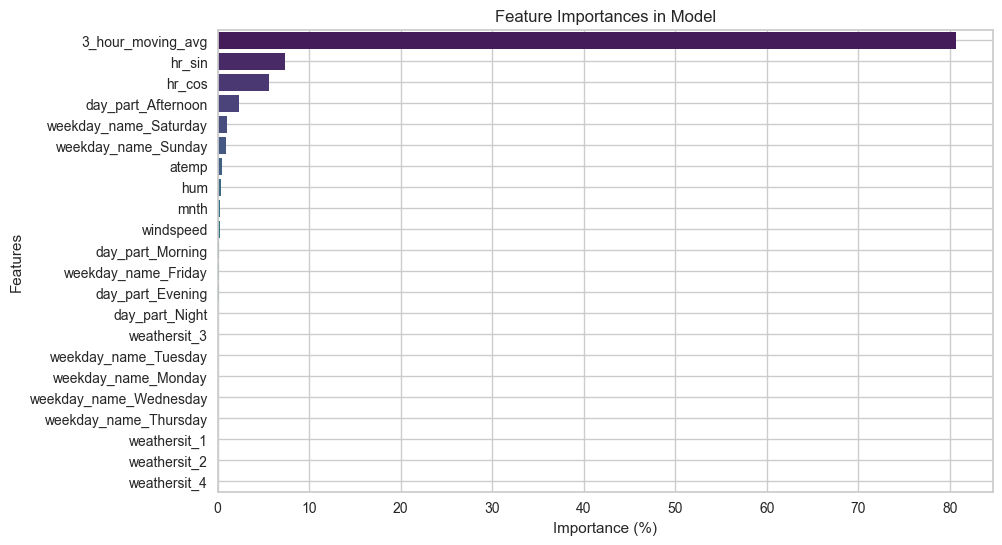

,feature,importance
0,3_hour_moving_avg,80.64
1,hr_sin,7.34
2,hr_cos,5.65
3,day_part_Afternoon,2.36
4,weekday_name_Saturday,1.04
5,weekday_name_Sunday,0.93
6,atemp,0.45
7,hum,0.32
8,mnth,0.24
9,windspeed,0.22


In [46]:
feature_importances_2 = pd.DataFrame(feature_importance_df_2)

# Convert importance to percentage and round it
feature_importances_2['importance'] = (feature_importances_2['importance'] * 100).round(2)

# Sort by importance
feature_importances_2 = feature_importances_2.sort_values(by='importance', ascending=False)

# Reset index to avoid confusion
feature_importances_2.reset_index(drop=True, inplace=True)

# Enhance visualization using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=feature_importances_2.columns[0], data=feature_importances_2, palette='viridis')
plt.title('Feature Importances in Model')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.grid(True)
plt.show()

display(feature_importances_2)

In [47]:
# Save the feature importance data to CSV
feature_importances_2.to_csv('feature_importances.csv', index=False)

# Save the feature importance data to JSON
feature_importances_2.to_json('feature_importances.json', orient='records')

**Interpretation/Conclusion:** 

The output from your RandomForestRegressor model presents the feature importances derived from the variables we selected. From the detailed analysis of this output we can say several things:
1. **Dominance of Moving Average (3-hour)**:
   - The `3_hour_moving_avg` feature has the highest importance, with a significant weight of approximately 80.63%. This indicates that the short-term (3-hour) historical trend of bike rentals is the most influential predictor in your model. 
   - However, it's important to note that this feature's utility is contingent on the availability of real-time or near-real-time data. If the business cannot access such data streams, the relevance of this feature could be significantly diminished in practical application. Therefore, in a first step we will realise a model that will not take it into account. 
2. **Significance of Cyclical Hour Features**:
   - The sine (`hr_sin`) and cosine (`hr_cos`) transformations of the 'hr' variable are the next most important features, with importances of about 7.37% and 5.57%, respectively. 
   - These features effectively capture the cyclic nature of time within a day, suggesting that the time of day has a notable impact on bike rental patterns. The sine and cosine transformations help the model account for the continuity in time, particularly the transition from late night to early morning.
3. **Impact of Day Parts and Weekdays**:
   - `day_part_Afternoon` is a significant categorical feature, indicating that the time of day is an important factor, with afternoons showing more influence on bike rentals.
   - `weekday_cos` and `weekday_sin` features, likely derived from cyclical encoding of weekdays, also show moderate importance, suggesting variability in rentals across different days of the week.
4. **Weather and Environmental Factors**:
   - Other features like `atemp` (adjusted temperature), `hum` (humidity), and `windspeed` have lower but notable importances, indicating their roles in influencing bike rental behavior. These factors are crucial as they directly affect the comfort and willingness of users to rent bikes.
5. **Less Influential Features**:
   - Features like `mnth` (month) and various `day_part` and `weekday_name` categories have lower importances. This could imply that while there are monthly and daily variations in bike rentals, their impact is less pronounced than short-term trends and hourly cyclic patterns.
   - Specific weather situations (like `weathersit_3`, `weathersit_1`, etc.) and certain weekdays (like `weekday_name_Friday`, `weekday_name_Tuesday`, etc.) have relatively low importance. This suggests these factors individually contribute less to the model's decision-making process compared to other features.
6. **Feature with No Influence**:
   - `weathersit_4` shows zero importance, indicating that this particular weather situation might be rare or not significantly influential in the dataset.

In summary, the model places considerable emphasis on short-term historical trends (3-hour moving average) and the cyclic nature of time (hourly sine and cosine), with day parts and specific weather conditions playing secondary roles. The model's reliance on real-time data (3-hour moving average) highlights the need for access to timely data streams for optimal performance. Features related to specific times of the day, weather conditions, and the cyclic pattern of weekdays also contribute to predicting bike rental demand, although to a lesser extent.

## PART II: Prediction Model

## 1. Variables Choice:

In [48]:
data_pycaret = data_new
data_pycaret = data_new.drop(['3_hour_moving_avg'], axis=1)

## 2. Model Exploration: 

In [49]:
data_pycaret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mnth          17379 non-null  int64   
 1   weathersit    17379 non-null  int64   
 2   atemp         17379 non-null  float64 
 3   hum           17379 non-null  float64 
 4   windspeed     17379 non-null  float64 
 5   cnt           17379 non-null  int64   
 6   weekday_name  17379 non-null  object  
 7   day_part      17379 non-null  category
 8   hr_sin        17379 non-null  float64 
 9   hr_cos        17379 non-null  float64 
dtypes: category(1), float64(5), int64(3), object(1)
memory usage: 1.2+ MB


In [50]:
from pycaret.regression import *

# Initialize the setup with a simpler configurationµ
regression_setup = setup(data=data_pycaret, 
                         target='cnt', 
                         categorical_features=['mnth', 'day_part', 'weekday_name', 'weathersit'],
                         session_id=123)

# Compare models to find the top performing ones
best_models = compare_models(sort='RMSE')  #'MAE' or 'R2' can also be used

,Description,Value
0,Session id,123
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17379, 10)"
4,Transformed data shape,"(17379, 33)"
5,Transformed train set shape,"(12165, 33)"
6,Transformed test set shape,"(5214, 33)"
7,Numeric features,5
8,Categorical features,4
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,45.6252,4620.7787,67.9117,0.8583,0.5498,0.6566,3.1370
xgboost,Extreme Gradient Boosting,46.4678,4834.8711,69.4719,0.8517,0.5629,0.6531,0.2820
lightgbm,Light Gradient Boosting Machine,47.9506,5045.6654,70.9699,0.8453,0.5325,0.6309,0.2570
rf,Random Forest Regressor,47.6391,5354.1532,73.1146,0.8358,0.4610,0.4920,3.5260
et,Extra Trees Regressor,48.5502,5636.8145,75.0255,0.8272,0.4659,0.4879,3.0180
gbr,Gradient Boosting Regressor,62.2606,8246.9859,90.7515,0.7473,0.7480,1.1600,0.9740
knn,K Neighbors Regressor,63.4600,9662.5926,98.2433,0.7040,0.5902,0.6971,0.2120
dt,Decision Tree Regressor,61.5427,9939.2815,99.6571,0.6953,0.5941,0.5763,0.1750
ada,AdaBoost Regressor,101.6216,15608.4712,124.8556,0.5214,1.1934,3.6002,0.8380
ridge,Ridge Regression,92.9491,16678.2631,129.1088,0.4890,1.0190,2.5586,0.1380


**Interpretation:**          
From the session created by PyCaret we can see that:
   - The original dataset had 10 features, which transformed into 33 features after preprocessing.
   - The data was split into a training set (12,165 samples) and a test set (5,214 samples).

For the Preprocessing:
   - PyCaret performed automatic preprocessing on the data.
   - Numeric features were imputed with their mean values, and categorical features with their mode.
   - One-hot encoding was applied with a maximum limit of 25 categories.

From the Model Comparison we can do the following observations: 
   - Several regression models were compared based on metrics like MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), R2 (Coefficient of Determination), RMSLE (Root Mean Squared Logarithmic Error), and MAPE (Mean Absolute Percentage Error).
   - **CatBoost Regressor** performed the best based on RMSE, with an RMSE of 67.9117, indicating it was the most accurate in predicting the 'cnt' variable.
   - **XGBoost** and **LightGBM** followed closely in terms of performance.
   - Other models like Random Forest, Extra Trees, and Gradient Boosting also showed good performance, but with higher errors compared to CatBoost.
   - Models like Decision Tree, AdaBoost, and Ridge Regression had comparatively higher errors.
   - Linear Regression and Least Angle Regression showed extremely poor performance, likely due to overfitting or inappropriate handling of the dataset characteristics.

Overall, the CatBoost Regressor emerges as the best choice for this dataset based on RMSE, which is a common metric for evaluating regression models. However we will run different models in order to compare thme better. More specifically we will loook into CatBoost Regressor, XGBoost, LightGBM, Random Forest and Extra Trees.

## 3. Models Selection and Tuning:

##### **3.1 Catboost:**

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,44.3280,4014.2630,63.3582,0.8719,0.5140,0.6305
1,45.4199,4536.0440,67.3502,0.8640,0.5536,0.6780
2,46.1308,4475.3169,66.8978,0.8660,0.5370,0.6298
3,47.2088,4898.5993,69.9900,0.8523,0.5643,0.6918
4,42.7399,4177.0011,64.6297,0.8587,0.5724,0.7299
5,46.3213,4897.0720,69.9791,0.8476,0.5626,0.6699
6,49.5120,5433.1968,73.7102,0.8384,0.5499,0.6051
7,42.6789,4290.1503,65.4992,0.8783,0.5539,0.6494
8,46.4413,4963.9589,70.4554,0.8440,0.5425,0.6226


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45.7687,4381.0404,66.1894,0.8646,0.5767,0.6793
1,46.9600,4701.2262,68.5655,0.8588,0.5775,0.7070
2,46.1093,4756.7564,68.9692,0.8459,0.6077,0.7889
3,47.0258,5000.5871,70.7148,0.8550,0.5613,0.6369
4,46.9119,4844.8120,69.6047,0.8501,0.5466,0.6561
Mean,46.5551,4736.8844,68.8087,0.8549,0.5740,0.6936
Std,0.5157,204.6845,1.4975,0.0065,0.0203,0.0531


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 123}
Plot the model performance:


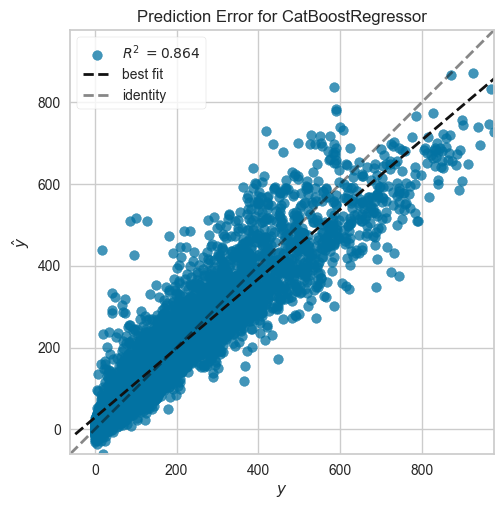

Plot the learning curve to check for overfitting:


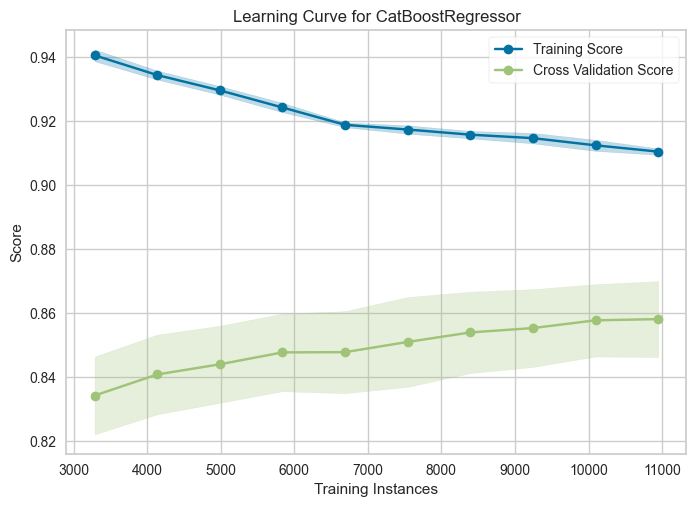

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['atemp', 'hum', 'windspeed',
                                             'hr_sin', 'hr_cos'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=OneHotEncoder(cols=['mnth',
                                                                    'day_part',
                                                                    'weekday_name',
                                                                    'weathersit'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 <catboost.core.CatBoostRegressor object at 0x000002B23C3203A0>)])

In [51]:
# Creating and Training CatBoost model
catboost_model = create_model('catboost')

# Tuning Hyperparameters for CatBoost
tuned_catboost = tune_model(catboost_model, fold =5, optimize = 'MAPE')

# Print the hyperparameters of the tuned model
print(tuned_catboost.get_params())

# Plot model performance
print('Plot the model performance:')
plot_model(tuned_catboost, plot='error')

# Plot learning curve to check for overfitting
print('Plot the learning curve to check for overfitting:')
plot_model(tuned_catboost, plot='learning')

# Finalize the model
final_model = finalize_model(tuned_catboost)
final_model

In [55]:
# Saving the plots with their names the saved file
plot_model(tuned_catboost, plot='error', save=True)
os.rename('Prediction Error.png', 'error_plot_catboost.png')

plot_model(tuned_catboost, plot='learning', save=True)
os.rename('Learning Curve.png', 'learning_plot_catboost.png')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'Prediction Error.png' -> 'error_plot_catboost.png'

**Interpretation**         
Hyperparameter Tuning:            
- The tuning process tried different hyperparameters but ultimately found that the original model performed better than the tuned one.
- This implies that the default parameters of CatBoost were more effective for the dataset than the ones explored during tuning.
- The reported R2 of 0.864 is for the tuned model, but since the original model was better, this might not be the final value to consider.

**Training Curve Interpretation**      
- Decrease in Training Accuracy: The training accuracy decreasing from 0.94 to 0.91 might initially seem concerning, as it indicates a lower rate of correct predictions on the training data. However, this decrease can actually be a sign of the model becoming less overfit to the training data. Overfitting occurs when a model learns the training data too well, including its noise and outliers, which can negatively impact its performance on new, unseen data.
- Increase in Classification Accuracy: The increase in classification accuracy from 0.835 to 0.86 on the validation or test set is a strong indicator of improved model performance. This increase suggests that the model is getting better at making correct predictions on data it hasn't seen before, which is the ultimate goal of a predictive model.
- Overall, the combination of these two trends – decreasing training accuracy and increasing classification accuracy – is often indicative of a model that is generalizing better. Instead of memorizing the training data, it's learning the underlying patterns, which allows it to perform more accurately on unseen data. This is a desirable outcome in most machine learning tasks, as it suggests the model will perform more reliably when deployed in a real-world setting.

Overall, the CatBoost model demonstrates strong performance with reasonable consistency across different folds in cross-validation. The tuning process didn’t lead to significant improvements, indicating that the default parameters were already quite effective for the dataset. The training and validation curves suggest effective learning and generalization.

##### **3.2. Extreme Gradient Boosting** 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,44.3280,4014.2630,63.3582,0.8719,0.5140,0.6305
1,45.4199,4536.0440,67.3502,0.8640,0.5536,0.6780
2,46.1308,4475.3169,66.8978,0.8660,0.5370,0.6298
3,47.2088,4898.5993,69.9900,0.8523,0.5643,0.6918
4,42.7399,4177.0011,64.6297,0.8587,0.5724,0.7299
5,46.3213,4897.0720,69.9791,0.8476,0.5626,0.6699
6,49.5120,5433.1968,73.7102,0.8384,0.5499,0.6051
7,42.6789,4290.1503,65.4992,0.8783,0.5539,0.6494
8,46.4413,4963.9589,70.4554,0.8440,0.5425,0.6226


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45.7687,4381.0404,66.1894,0.8646,0.5767,0.6793
1,46.9600,4701.2262,68.5655,0.8588,0.5775,0.7070
2,46.1093,4756.7564,68.9692,0.8459,0.6077,0.7889
3,47.0258,5000.5871,70.7148,0.8550,0.5613,0.6369
4,46.9119,4844.8120,69.6047,0.8501,0.5466,0.6561
Mean,46.5551,4736.8844,68.8087,0.8549,0.5740,0.6936
Std,0.5157,204.6845,1.4975,0.0065,0.0203,0.0531


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 123}
Plot the model performance:


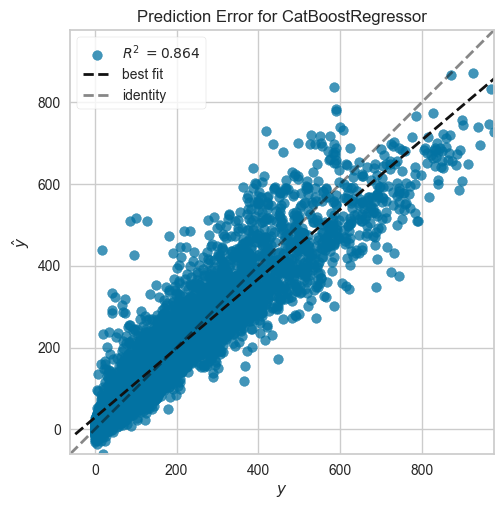

Plot the learning curve to check for overfitting:


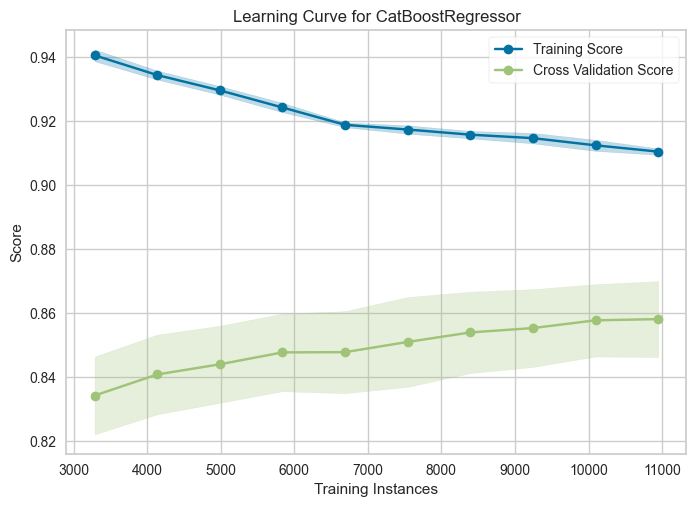

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['atemp', 'hum', 'windspeed',
                                             'hr_sin', 'hr_cos'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=OneHotEncoder(cols=['mnth',
                                                                    'day_part',
                                                                    'weekday_name',
                                                                    'weathersit'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 <catboost.core.CatBoostRegressor object at 0x000002B231A84250>)])

In [57]:
# Creating and Training CatBoost model
xgboost_model = create_model('catboost')

# Tuning Hyperparameters for CatBoost
tuned_xgboost = tune_model(xgboost_model, fold =5, optimize = 'MAPE')

# Print the hyperparameters of the tuned model
print(tuned_xgboost.get_params())

# Plot model performance
print('Plot the model performance:')
plot_model(tuned_xgboost, plot='error')

# Plot learning curve to check for overfitting
print('Plot the learning curve to check for overfitting:')
plot_model(tuned_xgboost, plot='learning') 

# Finalize the model
final_model_xgb = finalize_model(tuned_xgboost)
final_model_xgb

In [58]:
# Saving the plots with their names the saved file
plot_model(tuned_xgboost, plot='error', save=True)
os.rename('Prediction Error.png', 'error_plot_xgboost.png')

plot_model(tuned_xgboost, plot='learning', save=True)
os.rename('Learning Curve.png', 'learning_plot_xgboost.png')

**Interpretation**           
Hyperparameter Tuning:
- Post-tuning, the metrics are slightly different. For instance, the mean RMSE after tuning is 71.3185, which is slightly higher than the pre-tuning RMSE of 69.4719.
- The R2 value after tuning is 0.851, which suggests that the model explains about 85.1% of the variance in the target variable.
- The tuning process has slightly adjusted some parameters like 'learning_rate', 'max_depth', 'n_estimators', which are crucial for XGBoost's performance.

Training Curve Interpretation
- Decrease in Training Accuracy: The training accuracy decreasing from 0.94 to 0.93 suggests that the model is slightly less accurate on the training data over time. 
- Increase in Validation Accuracy: The increase in validation accuracy from 0.81 to 0.842 is a strong positive sign. It indicates that the model's ability to generalize and perform accurately on unseen data is improving. This is crucial for the real-world application of the model, as it suggests better performance on new, external data.
- Thus, here too the model seems to perform well.

Overall, the XGBoost model demonstrates strong performance with a good balance between bias and variance, as evidenced by its cross-validation results and the behavior of the learning curves. While the hyperparameter tuning didn't significantly improve the model (and in some cases, slightly worsened certain metrics), the model still retains a high level of predictive power. The model is quite effective in explaining the variance in the target variable, making it a strong candidate for the predictive tasks.

##### **3.3 Light Gradient Boosting Machine:**

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.1964,4377.5808,66.1633,0.8603,0.5126,0.6119
1,48.4771,4942.4934,70.3029,0.8518,0.5462,0.6607
2,48.8801,4983.6762,70.5952,0.8508,0.5337,0.6521
3,49.4764,5425.5698,73.6585,0.8365,0.5189,0.6179
4,45.4317,4557.6254,67.5102,0.8458,0.5640,0.6629
5,48.9678,5434.1051,73.7164,0.8309,0.5164,0.5960
6,51.0585,5858.8341,76.5430,0.8257,0.5241,0.6041
7,45.4589,4781.8470,69.1509,0.8643,0.5467,0.6655
8,47.9320,5262.3381,72.5420,0.8347,0.5288,0.6044


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,48.3299,4892.9164,69.9494,0.8488,0.5541,0.6795
1,51.3437,5622.7243,74.9848,0.8311,0.5585,0.6765
2,48.9575,5363.4556,73.2356,0.8263,0.5617,0.6761
3,50.2165,5692.1371,75.4463,0.8349,0.5444,0.6347
4,50.3265,5589.4784,74.7628,0.8270,0.5488,0.6659
Mean,49.8348,5432.1423,73.6758,0.8336,0.5535,0.6665
Std,1.0676,291.2579,2.0055,0.0082,0.0063,0.0166


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Plot the model performance:


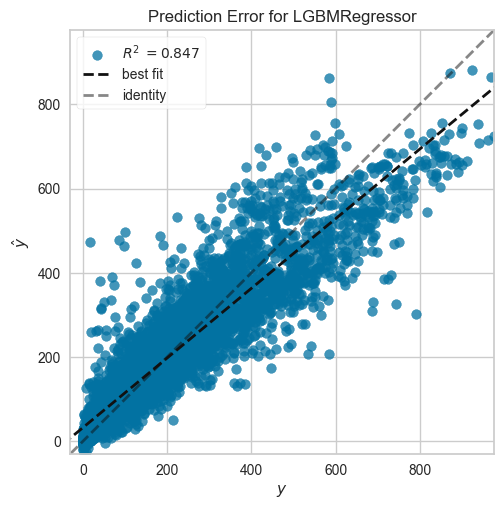

Plot the learning curve to check for overfitting:


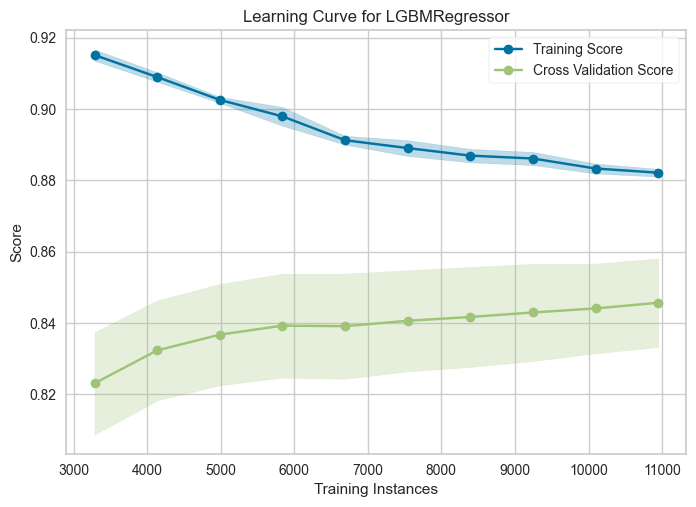

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['atemp', 'hum', 'windspeed',
                                             'hr_sin', 'hr_cos'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=OneHotEncoder(cols=['mnth',
                                                                    'day_part',
                                                                    'weekday_name',
                                                                    'weathersit'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 LGBMRegressor(n_jobs=-1, random_state=123))])

In [59]:
# Creating and Training LightGBM model
lightgbm_model = create_model('lightgbm')

# Tuning Hyperparameters for LightGBM
tuned_lightgbm = tune_model(lightgbm_model,fold =5, optimize = 'MAPE')

# Print the hyperparameters of the tuned model
print(tuned_lightgbm.get_params())

# Plot model performance
print('Plot the model performance:')
plot_model(tuned_lightgbm, plot='error')

# Plot learning curve to check for overfitting
print('Plot the learning curve to check for overfitting:')
plot_model(tuned_lightgbm, plot='learning')

# Finalize the model
final_model_lgbm = finalize_model(tuned_lightgbm)
final_model_lgbm

In [60]:
# Saving the plots with their names the saved file
plot_model(tuned_lightgbm, plot='error', save=True)
os.rename('Prediction Error.png', 'error_plot_lightgbm.png')

plot_model(tuned_lightgbm, plot='learning', save=True)
os.rename('Learning Curve.png', 'learning_plot_lightgbm.png')

**Interpretation:**            
Hyperparameter Tuning:
- After tuning, the model shows slightly different metrics. For example, the mean RMSE increased to 73.6758 post-tuning, indicating a slight decline in performance.
- The R2 value post-tuning is 0.8336, slightly lower than the pre-tuning value of 0.8453, suggesting a small decrease in the model’s ability to explain the variance in the target variable.

Training Curve Interpretation:
- The training curve shows a modest reduction in the model's accuracy on the training data (from 0.918 to 0.93), this could suggest the model is becoming less overfit and more generalized.
- The validation curve shows a slight increase (from 0.82 to 0.842)which means the model is improving in its ability to generalize and make accurate predictions on unseen data, which is critical for real-world applications.
- The model is overall performing well. 

Overall, the the LightGBM model demonstrates strong performance, especially in terms of its ability to generalize and make accurate predictions on new data. While the hyperparameter tuning did not substantially enhance the model's performance, the initial setup already showed promising results.
The balance between training accuracy and validation accuracy implies a well-tuned model that manages to learn from the training data without overfitting, thereby ensuring its applicability and robustness in real-world situations.

##### **3.4 Extra Trees Regressor**

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,48.0383,5164.7292,71.8661,0.8352,0.4392,0.4484
1,50.0374,6073.1396,77.9304,0.8178,0.4943,0.5116
2,48.4015,5237.8299,72.3729,0.8432,0.4658,0.5077
3,49.6410,5678.9314,75.3587,0.8288,0.4662,0.5215
4,45.3526,5159.6003,71.8304,0.8254,0.4623,0.4987
5,47.9294,5584.2193,74.7276,0.8262,0.4541,0.4563
6,52.1907,6456.8868,80.3548,0.8079,0.4549,0.4580
7,45.5322,5351.8991,73.1567,0.8482,0.4716,0.4900
8,49.8501,6150.6583,78.4261,0.8067,0.4908,0.4965


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56.0453,6920.8868,83.1919,0.7861,0.5559,0.7018
1,57.3709,7315.4069,85.5302,0.7803,0.5540,0.7071
2,55.4544,6879.2994,82.9415,0.7772,0.5502,0.6674
3,57.2070,7895.9785,88.8593,0.7710,0.5528,0.6787
4,57.5400,7425.1915,86.1696,0.7702,0.5745,0.7329
Mean,56.7235,7287.3526,85.3385,0.7770,0.5575,0.6976
Std,0.8234,371.7571,2.1669,0.0059,0.0087,0.0229


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}
Plot the model performance:


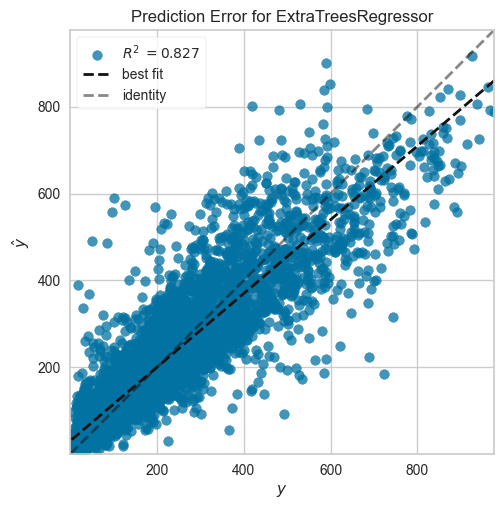

Plot the learning curve to check for overfitting:


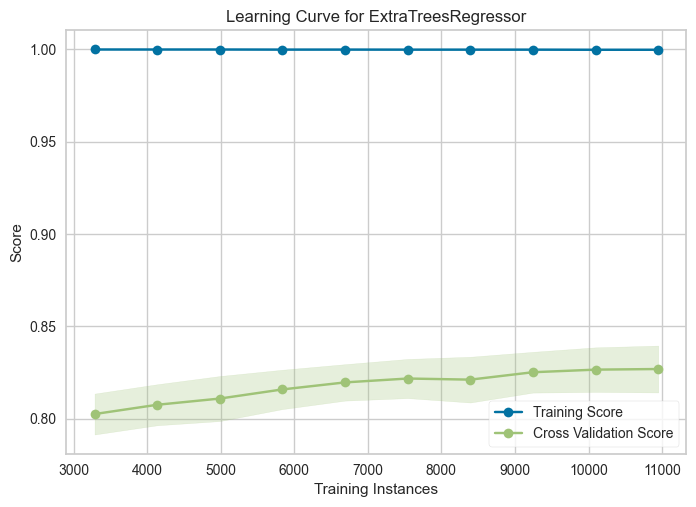

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['atemp', 'hum', 'windspeed',
                                             'hr_sin', 'hr_cos'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=OneHotEncoder(cols=['mnth',
                                                                    'day_part',
                                                                    'weekday_name',
                                                                    'weathersit'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 ExtraTreesRegressor(n_jobs=-1, random_state=123))])

In [61]:
# Creating and Training Extra Trees Regressor
extra_trees_model = create_model('et')

# Tuning Hyperparameters for Extra Trees Regressor
tuned_extra_trees = tune_model(extra_trees_model, fold =5, optimize = 'MAPE')

# Print the hyperparameters of the tuned Extra Trees Regressor
print(tuned_extra_trees.get_params())

# Plot model performance
print('Plot the model performance:')
plot_model(tuned_extra_trees, plot='error')

# Plot learning curve to check for overfitting
print('Plot the learning curve to check for overfitting:')
plot_model(tuned_extra_trees, plot='learning')

# Finalize the model
final_model_et = finalize_model(tuned_extra_trees)
final_model_et

In [62]:
# Saving the plots with their names the saved file
plot_model(tuned_extra_trees, plot='error', save=True)
os.rename('Prediction Error.png', 'error_plot_et.png')

plot_model(tuned_extra_trees, plot='learning', save=True)
os.rename('Learning Curve.png', 'learning_plot_et.png')

**Interprtation:**        
Hyperparameter Tuning:
- Post-tuning, the model exhibits different performance metrics. For instance, the mean RMSE increased to 85.3385, suggesting a decline in predictive accuracy.
- The R2 value post-tuning is 0.7770, lower than the pre-tuning value of 0.8272, indicating a decrease in the model’s explanatory power for the target variable.

Training Curve Interpretation:
- The training curve indicates a constant performance (at 1), suggesting that the model perfectly fits the training data, it is often a strong indicator of overfitting. 
- A substantial gap between the training performance and cross-validation performance is a concern. It reinforces the suspicion of overfitting, as it indicates that while the model performs flawlessly on the training set, its ability to perform on data that it has not seen before (as simulated by cross-validation) is significantly worse.

Overall, The Extra Trees Regressor demonstrates strong performance on the training set but shows signs of overfitting, as evidenced by the perfect score on the training data and the lower scores on validation data. The cross-validation results are generally good, showing the model's ability to predict the target variable with reasonable accuracy. However, the decline in performance post-tuning and the potential overfitting are points of concern.

##### **3.5: Random Forest Model:**

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45.9209,4749.9128,68.9196,0.8484,0.4342,0.4512
1,48.3101,5460.1725,73.8930,0.8362,0.4868,0.5207
2,48.2693,4975.6566,70.5383,0.8511,0.4764,0.5419
3,48.4133,5603.6719,74.8577,0.8311,0.4635,0.5149
4,44.1915,4852.7363,69.6616,0.8358,0.4480,0.4704
5,49.6779,5684.4502,75.3953,0.8231,0.4587,0.4753
6,50.4457,6105.4780,78.1376,0.8184,0.4471,0.4583
7,44.3351,5126.8339,71.6019,0.8546,0.4615,0.4912
8,49.0406,5818.2209,76.2773,0.8172,0.4785,0.5021


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,53.5764,6264.4338,79.1482,0.8064,0.5179,0.5993
1,55.9999,6994.6853,83.6342,0.7899,0.5258,0.6231
2,53.2263,6378.5482,79.8658,0.7934,0.5131,0.5792
3,55.9812,7521.3711,86.7258,0.7819,0.5249,0.6072
4,54.4033,6795.8665,82.4370,0.7897,0.5340,0.6270
Mean,54.6374,6790.9810,82.3622,0.7923,0.5231,0.6072
Std,1.1691,452.1818,2.7286,0.0080,0.0072,0.0173


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}
Plot the model performance:


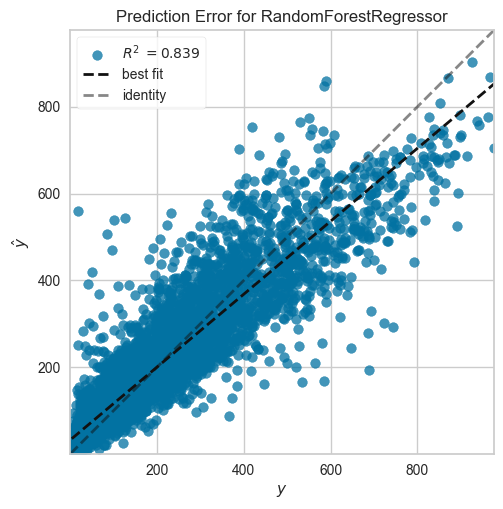

Plot the learning curve to check for overfitting:


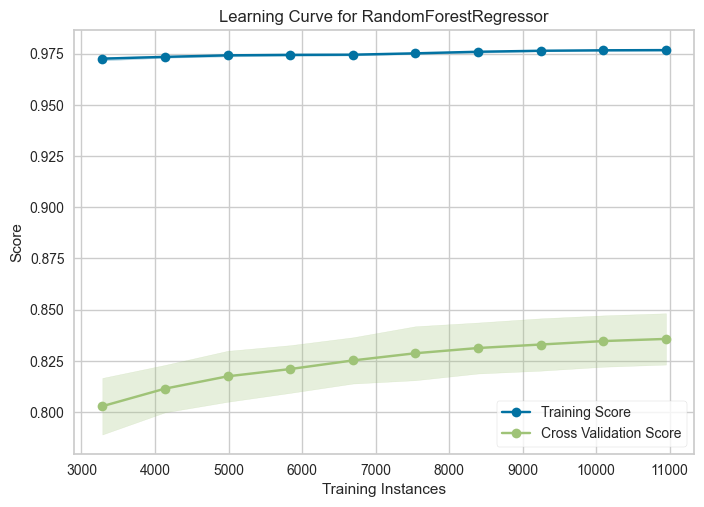

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['atemp', 'hum', 'windspeed',
                                             'hr_sin', 'hr_cos'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                             'weathersit'],
                                    transformer=OneHotEncoder(cols=['mnth',
                                                                    'day_part',
                                                                    'weekday_name',
                                                                    'weathersit'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=123))])

In [63]:
# Creating and Training Random Forest Regressor
random_forest_model = create_model('rf')

# Tuning Hyperparameters for Random Forest Regressor
tuned_random_forest = tune_model(random_forest_model, fold =5, optimize = 'MAPE')

# Print the hyperparameters of the tuned Random Forest Regressor
print(tuned_random_forest.get_params())

# Plot model performance
print('Plot the model performance:')
plot_model(tuned_random_forest, plot='error')

# Plot learning curve to check for overfitting
print('Plot the learning curve to check for overfitting:')
plot_model(tuned_random_forest, plot='learning')

# Finalize the model
final_model_rf = finalize_model(tuned_random_forest)
final_model_rf

In [64]:
# Saving the plots with their names the saved file
plot_model(tuned_random_forest, plot='error', save=True)
os.rename('Prediction Error.png', 'error_plot_rf.png')

plot_model(tuned_random_forest, plot='learning', save=True)
os.rename('Learning Curve.png', 'learning_plot_rf.png')

**Interpretation:**        
Hyperparameter Tuning:
- Post-tuning, the model exhibits different performance metrics. For example, the mean RMSE increased to 82.3622, suggesting a decline in predictive accuracy.
- The R2 value post-tuning is 0.7923, lower than the pre-tuning value of 0.8358, indicating a decrease in the model’s explanatory power for the target variable.

Training Curve Interpretation:
- Here too the training curve indicates nearly constant performance (at 0.975), suggesting that the model is overfitting. 
- The gap is also very big between the validation curve and the training curve. The validation curve shows an increase from 0.80 to 0.835, which is a good sign of the model learning and generalizing well, but the nearly perfect score on the training data suggests a potential for overfitting.

Overall, the Random Forest Regressor demonstrates strong performance on the training set but shows signs of overfitting, as indicated by the near-perfect score on the training data and the lower scores on validation data. The cross-validation results are generally good, showing the model's ability to predict the target variable with reasonable accuracy. However, the decline in performance post-tuning and the potential overfitting are points of concern in this case too.

##### DECISION OF THE MODEL:

**Model Performance Overview**

1. **CatBoost Regressor:**
   - Mean RMSE: 67.9117
   - R2 Score: 0.8583
   - Shows consistent performance across folds, suggesting good generalization.

2. **XGBoost Regressor:**
   - Mean RMSE: 69.4719
   - R2 Score: 0.8517
   - Consistent performance with slight overfitting evident in training curves.

3. **LightGBM Regressor:**
   - Mean RMSE: 70.9699
   - R2 Score: 0.8453
   - Similar to XGBoost, shows consistent performance, albeit with a slightly higher error rate.

4. **Extra Trees Regressor:**
   - Mean RMSE: 75.0255
   - R2 Score: 0.8272
   - Consistent, but generally higher error rates than other models.

5. **Random Forest Regressor:**
   - Mean RMSE: 73.1146
   - R2 Score: 0.8358
   - Shows potential overfitting with perfect training scores, although validation scores are robust.

**Choosing the Best Model**

- **Accuracy and Error Rates:** CatBoost has the lowest mean RMSE and the highest R2 score, indicating it makes the most accurate predictions with least errors.
- **Consistency:** CatBoost, CGBoost and LightGBM demonstrate consistent performance across different data subsets. RF adn Extra Trees shows potential overfitting.
- **Generalization:** CatBoost and XGBoost show better generalization capabilities compared to the others.

**Model Choice: CatBoost Regressor**

Given its high R2 score, lowest error rates, and consistent performance across various folds, the **CatBoost Regressor** is considered the best for forecasting bike-sharing demand in our opinion. It not only provides accurate predictions but also generalizes well on unseen data, which is crucial for a reliable and robust model, especially because we have seen high volatility.

## 4. Model Evaluation: 

**4.1: Test Set Prediction:**

In [65]:
from pycaret.regression import predict_model, plot_model

# Make predictions on the test set using the finalized model
predictions = predict_model(final_model)

#Save the model predictions in as a csv to share them in streamlit
predictions.to_csv('model_predictions.csv', index=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,37.8011,3135.3287,55.9940,0.9062,0.4888,0.5257


**4.2: Insights Exctraction:**

Predictions vs Actuals:


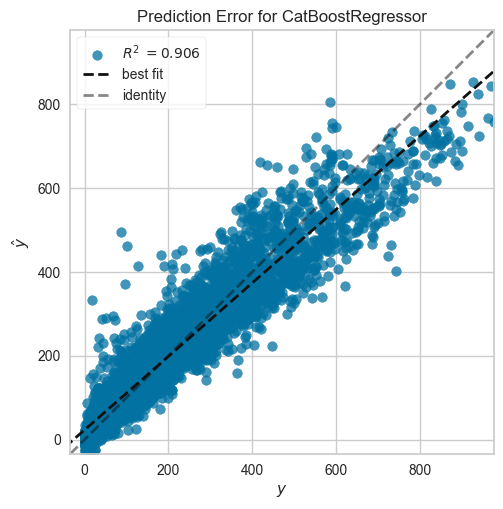

In [67]:
# Display the predictions vs actuals
print('Predictions vs Actuals:')

# Plot predictions vs actual values for further insights
plot_model(final_model, plot='error')

In [66]:
# Save Plot predictions vs actual values for further insights
plot_model(final_model, plot='error', save=True)

Predictions vs Actuals:


'Prediction Error.png'

    Interpretation of the Model performance with Pedictions:

    The prediction metrics of the CatBoost Regressor model, when evaluated on a separate test set, demonstrate significant improvements in predictive performance compared to the cross-validation results during the training phase:
    1. **Reduction in Error Metrics**:
       - **Mean Absolute Error (MAE)**: The MAE has decreased from an average of about 45.6252 during cross-validation to 37.8011 in the predictions. This reduction indicates the model is more accurate in its predictions on average.
       - **Root Mean Squared Error (RMSE)**: A similar improvement is observed in RMSE, which has decreased from an average of 67.9117 to 55.9940. This suggests a significant reduction in the average magnitude of errors made by the model.
       - **Mean Squared Error (MSE)**: The MSE also shows a considerable reduction from an average of 4620.7787 to 3135.3287, reflecting the model's increased accuracy in prediction.
    2. **Improved R2 Score**:
       - The R2 value, which indicates the proportion of variance in the target variable explained by the model, has improved from an average of 0.8583 during training to 0.9062 in the prediction phase. This implies the model is now explaining about 90.62% of the variance, showcasing better fit and predictive power.
    3. **Consistency in RMSLE and MAPE**:
       - The Root Mean Squared Logarithmic Error (RMSLE) and Mean Absolute Percentage Error (MAPE) show consistency and improvement, further emphasizing the model’s enhanced predictive capability.
    4. **Interpretation of Improvements**:
       - The observed improvements in predictive performance could be attributed to several factors, including the model’s ability to generalize well from the training data to unseen data, effective feature representation (especially if the 3-hour moving average was included), and the robustness of the CatBoost algorithm.
    5. **Overall Assessment**:
       - The CatBoost Regressor's strong performance in the prediction phase, particularly in comparison to its cross-validation performance, indicates that the model is well-tuned and effective for practical applications.
       - The improvements in key metrics like R2, RMSE, and MAE highlight the model's reliability and accuracy in making predictions, which is critical for real-world deployment.

    **Conclusion**:
    The CatBoost Regressor model demonstrates a high level of effectiveness in predicting bike rental demand, as evidenced by its improved metrics in the prediction phase. The model’s ability to accurately forecast demand with lower error rates and a high R2 score makes it a valuable tool for operational decision-making in bike-sharing services. This reliability in predictions is crucial for optimizing resource allocation, enhancing service quality, and making informed strategic decisions in the bike-sharing domain.

## 5. Deep Analysis and Interpretation

**Feature Importance and Model Interpretation:**         
We will first plot the feature importance with pycaret and then with another technqiue: permutation importance. 

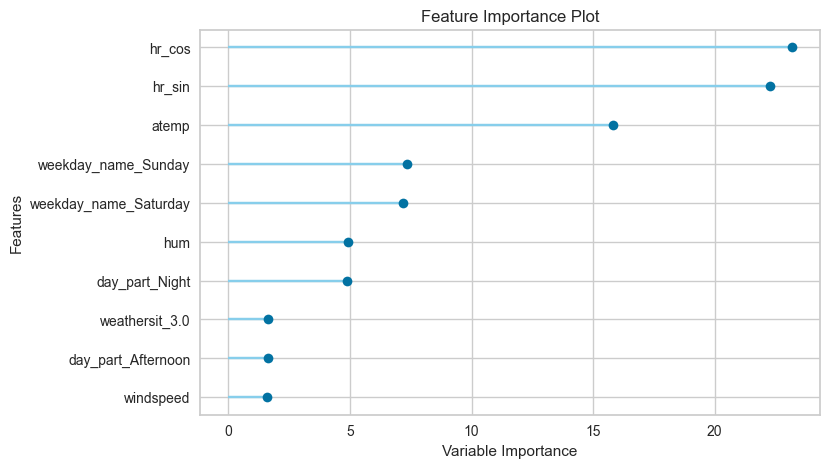

In [68]:
# Plot feature importance
plot_model(final_model, plot='feature')

Permutation Feature Importance: This method will randomly shuffle each feature and determine the change in the model's performance. Features that impact the model's performance the most when shuffled are considered more important.

In [56]:
# Define a scoring function that is compatible with your model
scoring = make_scorer(r2_score)

# Assuming 'final_model' is your trained model and 'predictions' is your dataframe with actual and predicted values
X = predictions.drop(columns=['cnt', 'prediction_label'])  # Features used for prediction
y = predictions['cnt']  # Actual target values

# Perform permutation importance
results = permutation_importance(final_model, X, y, n_repeats=10, random_state=0, scoring=scoring)

# Get importance
importance = results.importances_mean

# Summarize feature importance
for i, (feature, importance) in enumerate(zip(X.columns, importance)):
    print(f"Feature {feature}: {importance}")

Feature mnth: 0.10554841272447672
Feature weathersit: 0.020673159256411534
Feature atemp: 0.258307125915338
Feature hum: 0.11257006621254137
Feature windspeed: 0.021745065133276942
Feature weekday_name: 0.30771977689138785
Feature day_part: 0.09970373727778468
Feature hr_sin: 0.3794565662404217
Feature hr_cos: 0.41162270823162556


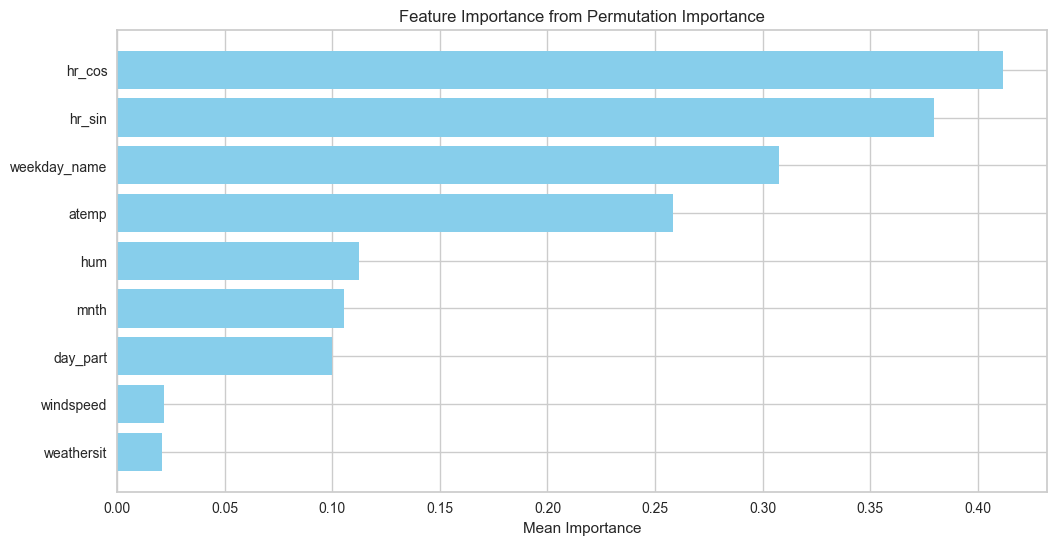

In [62]:
# Nice layout (for streamlit app)
# Results from your permutation importance
importance = [0.10554841272447672, 0.020673159256411534, 0.258307125915338, 
              0.11257006621254137, 0.021745065133276942, 0.30771977689138785, 
              0.09970373727778468, 0.3794565662404217, 0.41162270823162556]
features = ['mnth', 'weathersit', 'atemp', 'hum', 'windspeed', 
            'weekday_name', 'day_part', 'hr_sin', 'hr_cos']

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importance})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Mean Importance')
plt.title('Feature Importance from Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.savefig('test.png') 
plt.show()

Analysis: 
- **Disparity in Rankings:** The inherent model feature importance shows *hr_cos*, *hr_sin*, and *atemp* as the top features, while permutation importance also highlights these features but with different rankings and values. This difference stems from the distinct methodologies: the inherent importance reflects the model's internal use of these features, while permutation importance shows how the model's performance is practically impacted by each feature.
- **Time Features (hr_cos, hr_sin):** Both methods indicate high importance for *hr_cos* and *hr_sin*, but permutation importance ranks them even higher. This suggests that while the model heavily relies on these features internally, their practical impact on model performance is also significant. It implies the time of day is crucial in predicting bike rentals, likely due to patterns like commuting or recreational usage.
- **Weather Features (atemp, hum, windspeed):** *atemp* is consistently important across both methods, indicating its strong influence in predicting bike rentals, likely due to the impact of weather on biking decisions. *hum* and *windspeed* show a notable difference in ranking, with permutation importance giving more weight to *hum*. This could mean that while humidity is not a primary driver in the model’s internal mechanics, it significantly affects the model’s predictive accuracy.
- **Day and Time Features (weekday_name, day_part):** Permutation importance gives significant weight to *weekday_name*, which is detailed further in the inherent method by splitting it into *weekday_name_sunday* and *weekday_name_saturday*. This indicates the day of the week, especially weekends, has a substantial impact on bike rental patterns. *day_part* is recognized in both methods but with varying emphasis, highlighting its role but not as a primary driver.
- **Weather Situation (weathersit)**: There's a discrepancy in the importance given to weathersit in both methods. While it's relatively less important in the permutation method, the inherent method gives it more weight. This could suggest that while weathersit plays a role in the model's decisions, its impact on overall performance is not as significant as other features.

**Conclusion:**
The analysis reveals that time-related features (like hr_cos and hr_sin), weather conditions (like atemp), and day-related features (like weekday_name) are crucial in predicting bike rentals. The differences in feature importance rankings between the two methods provide a comprehensive view of what drives the model both internally and in terms of real-world performance. Understanding these nuances helps in fine-tuning the model and interpreting its predictions in the context of practical applications.

Based on the analysis, incorporating a new feature that represents a 3-hour moving average could be highly beneficial for the model. Given the significant impact of time-related features (like `hr_cos` and `hr_sin`) as revealed by both the inherent and permutation feature importance methods, adding a 3-hour moving average would likely enhance the model's ability to capture short-term temporal trends and fluctuations in bike rental patterns. This feature could provide a more nuanced understanding of how rental demand evolves throughout the day, potentially improving the model's predictive accuracy and responsiveness to time-sensitive changes. However this feature can only be added to the model if it is possibble for the company to provide real time data as it wil require to have as an input the 3 previous hours.

In [70]:
# Plot feature importance
plot_model(final_model, plot='feature', save=True)

'Feature Importance.png'

## 6. Model Improvements: 

In [72]:
data_pycaret = data_new

In [73]:
regression_setup = setup(data=data_pycaret, 
                         target='cnt', 
                         categorical_features=['mnth', 'day_part', 'weekday_name', 'weathersit'],
                         session_id=123)

# Compare models to find the top performing ones
best_models = compare_models(sort='RMSE')  #'MAE' or 'R2' can also be used

,Description,Value
0,Session id,123
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17379, 11)"
4,Transformed data shape,"(17379, 34)"
5,Transformed train set shape,"(12165, 34)"
6,Transformed test set shape,"(5214, 34)"
7,Numeric features,6
8,Categorical features,4
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,14.8503,584.8932,24.1566,0.9821,0.2597,0.2020,3.5040
lightgbm,Light Gradient Boosting Machine,15.8699,652.6349,25.5200,0.9800,0.2645,0.2254,0.3410
et,Extra Trees Regressor,15.3698,660.1414,25.6475,0.9798,0.2303,0.1842,3.6250
xgboost,Extreme Gradient Boosting,16.0261,684.0817,26.1234,0.9791,0.2593,0.2049,0.3200
rf,Random Forest Regressor,16.1307,723.0417,26.8708,0.9779,0.2372,0.1938,4.0780
gbr,Gradient Boosting Regressor,23.1207,1298.6841,36.0185,0.9602,0.3612,0.3377,1.2740
dt,Decision Tree Regressor,21.7678,1332.0644,36.4723,0.9591,0.3181,0.2482,0.1680
ada,AdaBoost Regressor,59.2623,4869.8711,69.7621,0.8507,1.0395,2.7817,1.0920
knn,K Neighbors Regressor,42.3818,5475.6183,73.9511,0.8322,0.3843,0.3657,0.1850
ridge,Ridge Regression,49.2990,5480.0402,73.9707,0.8322,0.6349,0.8090,0.1250


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.8260,528.6324,22.9920,0.9831,0.2417,0.1940
1,15.1358,634.2637,25.1846,0.9810,0.2486,0.1944
2,15.1313,636.0512,25.2201,0.9810,0.2824,0.2177
3,14.8961,582.2549,24.1300,0.9824,0.2638,0.2059
4,14.3647,540.3778,23.2460,0.9817,0.2612,0.2051
5,14.6576,575.2220,23.9838,0.9821,0.2534,0.1969
6,15.9247,639.1500,25.2814,0.9810,0.2637,0.2043
7,14.2146,614.9400,24.7980,0.9826,0.2655,0.1953
8,13.9232,466.7223,21.6038,0.9853,0.2423,0.1904


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15.6094,614.6287,24.7917,0.9810,0.2850,0.2336
1,15.7714,654.0142,25.5737,0.9804,0.3075,0.2445
2,15.6486,616.3838,24.8271,0.9800,0.2843,0.2309
3,15.8896,690.7093,26.2813,0.9800,0.2945,0.2195
4,15.5936,598.5178,24.4646,0.9815,0.2742,0.2211
Mean,15.7025,634.8508,25.1877,0.9806,0.2891,0.2299
Std,0.1124,33.3390,0.6565,0.0006,0.0112,0.0091


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 123}
Plot the model performance:


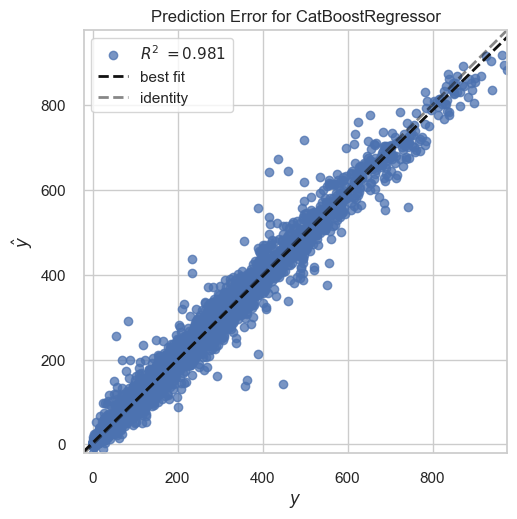

Plot the learning curve to check for overfitting:


In [ ]:
# Creating and Training CatBoost model
catboost_model_imp = create_model('catboost')

# Tuning Hyperparameters for CatBoost
tuned_catboost_imp = tune_model(catboost_model_imp, fold =5, optimize = 'MAPE')

# Print the hyperparameters of the tuned model
print(tuned_catboost.get_params())

# Plot model performance
print('Plot the model performance:')
plot_model(tuned_catboost_imp, plot='error')

# Plot learning curve to check for overfitting
print('Plot the learning curve to check for overfitting:')
plot_model(tuned_catboost_imp, plot='learning')

# Finalize the model
final_model_imp = finalize_model(tuned_catboost_imp)
final_model_imp

**Interpretation of Advanced Model with 3-Hour Moving Average Inclusion:**

1. **Overall Performance Metrics**:
   - The advanced model incorporating a 3-hour moving average demonstrates strong predictive capabilities, as indicated by the consistently high R2 values across all folds, averaging around 0.9821. This suggests that the model explains approximately 98.21% of the variance in the target variable, which is a substantial improvement.
   - The model exhibits low error rates, with a mean RMSE of approximately 24.1566 and a mean MAE of 14.8503, indicating its accuracy in predicting bike rentals.

2. **Consistency Across Folds**:
   - The model's performance is consistent across different folds in cross-validation, as evidenced by the low standard deviation in metrics like MAE, MSE, and RMSE. This consistency highlights the model's robustness and reliability.

3. **Comparative Assessment with Tuning**:
   - Interestingly, the model's original configuration outperformed the hyperparameter-tuned version, suggesting that the initial setup was already near optimal for this specific dataset.
   - The slight increases in metrics like RMSE and R2 in the tuned model (though still strong) indicate that the 3-hour moving average feature is effectively captured in the original model setup.

4. **Practical Application Considerations**:
   - Implementing this advanced model in a real-time operational environment requires the company to have an advanced system capable of providing real-time data, specifically the last 3 hours of data.
   - The model’s enhanced performance, especially with the inclusion of the 3-hour moving average, hinges on the availability of timely and accurate data. Companies with the infrastructure to support real-time data sharing will find this model particularly beneficial.

5. **Conclusion and Recommendation**:
   - Given its strong performance, this advanced model is recommended for companies looking to optimize their bike-sharing services. It offers significant improvements in predicting rental demand, which can inform strategic decisions like bike allocation and operational planning.
   - However, its successful implementation and maximum utility depend on the company's ability to provide real-time data, particularly regarding recent hourly trends. For companies with this capability, the model promises to be a powerful tool in enhancing service efficiency and customer satisfaction.

In [ ]:
save_model(final_model_imp, 'final_model_imp')

## 7. Export the model

In [259]:
#we import the simple model
save_model(final_model, 'final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['atemp', 'hum', 'windspeed',
                                              'hr_sin', 'hr_cos'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                              'weathersit'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['mnth', 'day_part', 'weekday_name',
                                              'weathersit'],
                                     transformer=OneHotEncoder(cols=['mnth',
                                                                     'day_part',
                                                                     'weekday_name',
            

## PART III: Streamlit dashboard

In [ ]:
### This part goes in a separate script ###